In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from time import time
import seaborn as sns
import pandas as pd
sns.set(rc={'figure.figsize':(12,8)})

# mne import
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, Xdawn)
from mne.time_frequency import AverageTFR
from mne.channels import make_standard_montage
from mne.decoding import LinearModel, Vectorizer, get_coef, Scaler, CSP, SPoC, UnsupervisedSpatialFilter
from mne.time_frequency import psd_welch
mne.set_log_level('WARNING')

import sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [18]:
# Define a monte-carlo cross-validation generator (reduce variance):
def csp_lda(epochs_data,labels):
    x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.3, random_state=42, shuffle=True)
#     cv = ShuffleSplit(10, test_size=0.4, random_state=42)

    # # Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = make_pipeline(csp, lda).fit(x_train, y_train)
#     scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)
    return clf.score(x_test, y_test)

In [19]:
# Define a monte-carlo cross-validation generator (reduce variance):
def csp_log_reg(epochs_data,labels):
    x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.3, random_state=42, shuffle=True)
#     cv = ShuffleSplit(10, test_size=0.4, random_state=42)

    # # Assemble a classifier
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    log_reg = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto')

    # Use scikit-learn Pipeline with cross_val_score function
    clf = make_pipeline(csp, log_reg).fit(x_train, y_train)
#     scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)
    return clf.score(x_test, y_test)

In [20]:
# Define a monte-carlo cross-validation generator (reduce variance):
def csp_rfc(epochs_data,labels):
    x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.3, random_state=42, shuffle=True)

    # # Assemble a classifier
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    rfc = RandomForestClassifier(random_state=42)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = make_pipeline(csp, rfc).fit(x_train, y_train)
    return clf.score(x_test, y_test)

In [21]:
# Define a monte-carlo cross-validation generator (reduce variance):
def spoc_log_reg(epochs_data,labels):
    x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.3, random_state=42, shuffle=True)
#     cv = ShuffleSplit(10, test_size=0.4, random_state=42)

    # # Assemble a classifier
    spoc = SPoC(n_components=10, log=True, reg='oas', rank='full')
    log_reg = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto')

    # Use scikit-learn Pipeline with cross_val_score function
    clf = make_pipeline(spoc, log_reg).fit(x_train, y_train)
#     scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)
    return clf.score(x_test, y_test)

In [22]:
# Define a monte-carlo cross-validation generator (reduce variance):
def spoc_lda(epochs_data,labels):
    x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.3, random_state=42, shuffle=True)
#     cv = ShuffleSplit(10, test_size=0.4, random_state=42)

    # # Assemble a classifier
    spoc = SPoC(n_components=10, log=True, reg='oas', rank='full')
    lda = LinearDiscriminantAnalysis()

    # Use scikit-learn Pipeline with cross_val_score function
    clf = make_pipeline(spoc, lda).fit(x_train, y_train)
#     scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)
    return clf.score(x_test, y_test)

In [23]:
# Define a monte-carlo cross-validation generator (reduce variance):
def spoc_rfc(epochs_data,labels):
    x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.3, random_state=42, shuffle=True)

    # # Assemble a classifier
    spoc = SPoC(n_components=10, log=True, reg='oas', rank='full')
    rfc = RandomForestClassifier(random_state=42)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = make_pipeline(spoc, rfc).fit(x_train, y_train)
    return clf.score(x_test, y_test)

In [3]:
def csp_svm_pipeline(epochs_data,labels):
    x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.3, random_state=42, shuffle=True)
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    svc = SVC()
    clf = Pipeline([('csp', csp), ('svc', svc)]).fit(x_train, y_train)
    return clf.score(x_test, y_test)

In [4]:
def csp_svm_fitOnce(epochs_data,labels):
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    data = csp.fit_transform(epochs_data, labels)
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42, shuffle=True)
    svc = SVC().fit(x_train,y_train)
    return svc.score(x_test, y_test)

In [5]:
def csp_svm_fitTwice(epochs_data,labels):
    x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.3, random_state=42, shuffle=True)
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    x_train = csp.fit_transform(x_train, y_train)
    x_test = csp.fit_transform(x_test, y_test)
    svc = SVC().fit(x_train, y_train)
    return svc.score(x_test, y_test)

In [16]:
# random forest
def rfc(data):
    x = data[[*np.arange(0, len(epochs_data[0]))]]
    y = data['label'].astype('int64')

    x_train,x_test,y_train,y_test = train_test_split(x,y)

    rfc = RandomForestClassifier().fit(x_train,y_train)
    return rfc.score(x_test, y_test)

In [17]:
# svm
def svm(data):
    x = data[[*np.arange(0, len(epochs_data[0]))]]
    y = data['label'].astype('int64')

    scaler = StandardScaler()
    scaler.fit(x)
    x= scaler.transform(x)

    x_train,x_test,y_train,y_test = train_test_split(x,y)

    svc = SVC().fit(x_train,y_train)
    return svc.score(x_test, y_test)

In [8]:
dates = [720,721,723,724,725,726,727,728,729,730,731,731,801,801,802,804,804]
persons = ['dzq','zyy','wsy','lzz','fcx','zjs','thn','lj','cs','lzr','hyb','wzx','tjq','cfl','lpy','dzq2','lgm']
nums = [3, 5, 4, 6, 5, 7, 4, 3, 3, 6, 4, 6, 5, 6, 6, 4, 6]

In [28]:
i = 1
person = persons[i]
num = nums[i]
date = dates[i]
raw_files = []
# import data
for j in range(num):
    f = "E:\大创\data\EEG/0{}{}_eyesImagine{}-edf-pre.edf".format(date, person, j + 1)
    raw_file = read_raw_edf(f, preload=True, stim_channel='auto')
    raw_files.append(raw_file)

In [29]:
raw_files

[<RawEDF | 0721zyy_eyesImagine1-edf-pre.edf, 32 x 121500 (243.0 s), ~29.7 MB, data loaded>,
 <RawEDF | 0721zyy_eyesImagine2-edf-pre.edf, 32 x 118500 (237.0 s), ~29.0 MB, data loaded>,
 <RawEDF | 0721zyy_eyesImagine3-edf-pre.edf, 32 x 233500 (467.0 s), ~57.0 MB, data loaded>,
 <RawEDF | 0721zyy_eyesImagine4-edf-pre.edf, 32 x 230000 (460.0 s), ~56.2 MB, data loaded>,
 <RawEDF | 0721zyy_eyesImagine5-edf-pre.edf, 32 x 230500 (461.0 s), ~56.3 MB, data loaded>]

In [30]:
raw = concatenate_raws(raw_files)
events, event_dict = mne.events_from_annotations(raw)
# event2, event_dict2 = mne.events_from_annotations(raw, event_id = {'S  2': 4})
# print(raw.info)
# print(event_dict)
# print(events)

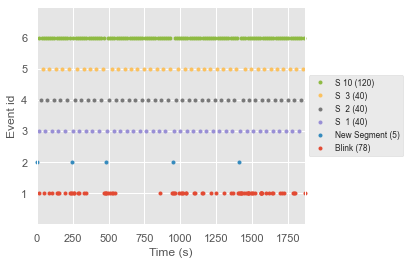

In [31]:
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend

In [32]:
subkey = ['S  1','S  2','S  3','S 10']
print(dict([(key, event_dict[key]) for key in subkey]))
event_ids = dict([(key, event_dict[key]) for key in subkey])

{'S  1': 3, 'S  2': 4, 'S  3': 5, 'S 10': 6}


In [33]:
event_id_compose = [{'S  1':event_ids['S  1'], 'S  2':event_ids['S  2']},
                    {'S  1':event_ids['S  1'], 'S  3':event_ids['S  3']},
                    {'S  2':event_ids['S  2'], 'S  3':event_ids['S  3']},
                    {'S  1':event_ids['S  1'], 'S 10':event_ids['S 10']},
                    {'S  2':event_ids['S  2'], 'S 10':event_ids['S 10']},
                    {'S  3':event_ids['S  3'], 'S 10':event_ids['S 10']}]

In [36]:
acc = []
for event_id in event_id_compose:
    print(event_id)
    tmin, tmax = -0.5, 4.5
    picks = pick_types(raw.info, meg=False, eeg=True, stim=True, eog=False)
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
    epochs_data = epochs.get_data()
    labels = epochs.events[:, -1]
    temp = labels.min()
    labels = labels - temp

    acc.append(csp_log_reg(epochs_data, labels))
    acc.append(csp_lda(epochs_data, labels))
    acc.append(csp_rfc(epochs_data, labels))
    acc.append(spoc_log_reg(epochs_data, labels))
    acc.append(spoc_lda(epochs_data, labels))
    acc.append(spoc_rfc(epochs_data, labels))
    print(acc)

{'S  1': 3, 'S  2': 4}
[0.4583333333333333, 0.5833333333333334, 0.5416666666666666, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334]
{'S  1': 3, 'S  3': 5}
[0.4583333333333333, 0.5833333333333334, 0.5416666666666666, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 1.0, 1.0]
{'S  2': 4, 'S  3': 5}
[0.4583333333333333, 0.5833333333333334, 0.5416666666666666, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
{'S  1': 3, 'S 10': 6}
[0.4583333333333333, 0.5833333333333334, 0.5416666666666666, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9791666666666666, 0.9791666666666666, 0.9583333333333334, 0.9791666666666666, 0.9791666666666666, 0.9583333333333334]
{'S  2': 4, 'S 10': 6}
[0.4583333333333333, 0.5833333333333334, 0.5416666666666666, 0.5833333333333334, 0.583

[Text(0.25, 0, 'See-Imagine Vs See-Unimagine'),
 Text(1.25, 0, 'See-Unimagine Vs Unsee-Imagine'),
 Text(2.25, 0, 'See-Imagine Vs Unsee-Imagine'),
 Text(3.25, 0, 'See-Unimagine Vs Unsee-Unimagine'),
 Text(4.25, 0, 'See-Imagine Vs Unsee-Unimagine'),
 Text(5.25, 0, 'Unsee-Imagine Vs Unsee-Unimagine')]

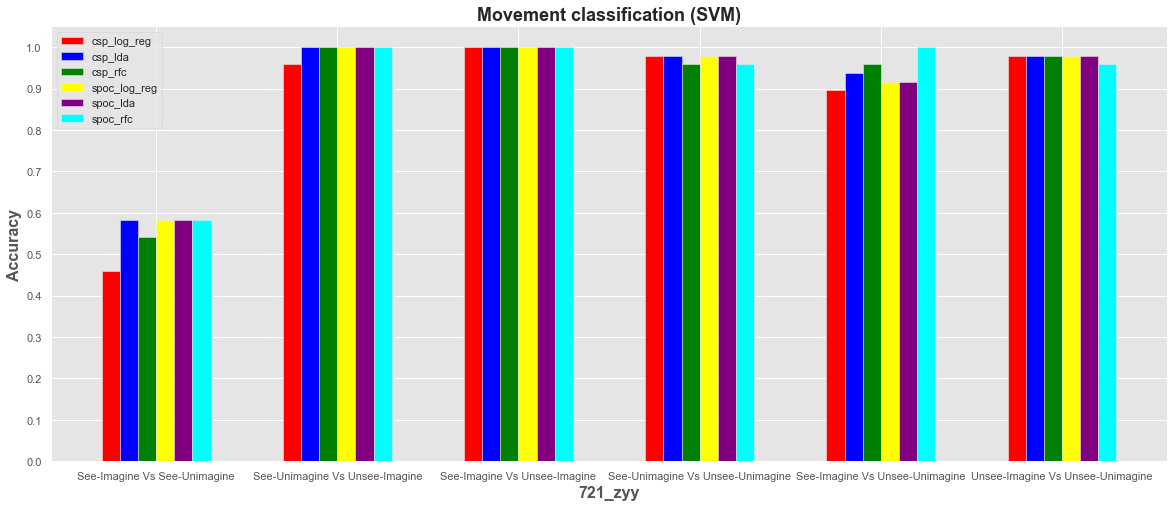

In [35]:
%matplotlib inline
plt.style.use("ggplot")
states = ["See-Imagine Vs See-Unimagine", "See-Unimagine Vs Unsee-Imagine","See-Imagine Vs Unsee-Imagine",\
         "See-Unimagine Vs Unsee-Unimagine","See-Imagine Vs Unsee-Unimagine","Unsee-Imagine Vs Unsee-Unimagine"]
csp_log_reg_r = acc[::6]
csp_lda_r = acc[1::6]
csp_rfc_r = acc[2::6]
spoc_log_reg_r = acc[3::6]
spoc_lda_r = acc[4::6]
spoc_rfc_r = acc[5::6]

# 创建分组柱状图，需要自己控制x轴坐标
xticks = np.arange(len(states))

fig, ax = plt.subplots(figsize=(20, 8))

ax.bar(xticks, csp_log_reg_r, width=0.1, label="csp_log_reg", color="red")

ax.bar(xticks + 0.1, csp_lda_r, width=0.1, label="csp_lda", color="blue")

ax.bar(xticks + 0.2, csp_rfc_r, width=0.1, label="csp_rfc", color="green")

ax.bar(xticks + 0.3, spoc_log_reg_r, width=0.1, label="spoc_log_reg", color="yellow")

ax.bar(xticks + 0.4, spoc_lda_r, width=0.1, label="spoc_lda", color="purple")

ax.bar(xticks + 0.5, spoc_rfc_r, width=0.1, label="spoc_rfc", color="cyan")

ax.set_title("Movement classification (SVM)", fontsize=18, fontweight='heavy')
ax.set_xlabel("{}_{}".format(date,person), fontsize=16, fontweight='heavy')
ax.set_ylabel("Accuracy", fontsize=16, fontweight='heavy')
plt.yticks(np.arange(0, 1.1, 0.1))
ax.legend()

# 最后调整x轴标签的位置
ax.set_xticks(xticks + 0.25)
ax.set_xticklabels(states)
# plt.savefig("{}_{}".format(date,persons), bbox_inches='tight')

In [127]:
# intervals = [0.1, 0.2, 0.5]
# for interval in intervals:
#     slot_num = int(5 / interval)
#     step = int(2500 / slot_num)
#     data = []
#     for epoch in epochs_data:
#         archer = 0
#         tmp = np.delete(epoch, 0, axis=1)
#         for slot_id in range(slot_num):
#             inner = []
#             archer = archer + step
#             for channel in range(len(tmp)):
#                 inner.append(tmp[channel][archer - step : archer])
#             data.append(inner)
#     data = np.array(data)
#     print(data.shape)

(2500, 32, 50)
(1250, 32, 100)
(500, 32, 250)


In [14]:
# data = pd.DataFrame(columns=[*np.arange(0, len(epochs_data[i])), 'label'])
# for i in range(len(epochs_data)):
#     tmp = pd.DataFrame(epochs_data[i]).transpose()
#     tmp['label'] = labels[i]
#     data = pd.concat([data, tmp], axis=0)
# data

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
0,6.785858,10.284098,4.742197,0.352456,12.767906,13.482684,12.231898,2.565244,0.846265,10.405226,...,2.126028,-7.587987,-6.078798,-1.506389,5.511740,3.444133,2.651885,1.781886,7.808681,1
1,7.807995,11.786467,6.329403,1.171065,14.712844,14.742224,13.964696,3.206293,-2.112688,11.728579,...,3.419748,-6.392840,-5.348644,-0.143736,6.673921,4.279029,3.215955,2.718709,8.857325,1
2,8.664381,13.090448,7.877762,1.791518,16.069018,15.696370,15.426515,4.337556,-4.607445,12.847083,...,4.558928,-5.178571,-4.615806,1.011027,7.511933,4.746156,3.719454,3.592612,9.613077,1
3,9.161637,13.919128,9.143088,2.067636,16.675396,16.151983,16.394301,5.688787,-6.104776,13.565942,...,5.330156,-4.160306,-4.041347,1.728897,7.867140,4.738741,4.010953,4.204343,9.871065,1
4,9.212283,14.119581,9.981089,1.957189,16.521914,15.983605,16.735331,6.979265,-6.319020,13.768278,...,5.608327,-3.488633,-3.713852,1.894559,7.661947,4.262717,4.022310,4.445540,9.525058,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,-5.436694,-5.371746,-3.426179,-5.308274,-3.165405,-2.994068,-2.299403,-5.278364,5.113494,0.153432,...,3.561811,-4.399594,-0.794803,-3.278076,-2.998067,-4.539605,-6.406907,-5.504736,-3.062085,1
2497,-5.872059,-5.317912,-3.439948,-5.034394,-3.043460,-3.543407,-2.093734,-5.195553,6.645355,0.013848,...,2.876146,-4.777932,-0.969246,-3.447417,-4.148613,-5.547395,-6.940441,-5.772942,-3.802012,1
2498,-5.904251,-4.959018,-3.224234,-4.466018,-2.671424,-3.921006,-1.685713,-4.537848,7.577466,-0.017171,...,2.321507,-4.337478,-0.786081,-3.175143,-5.192105,-6.291493,-6.925454,-5.649512,-4.401104,1
2499,-5.488815,-4.298653,-2.774448,-3.659102,-2.036896,-4.021093,-1.148320,-3.461314,7.804872,0.074778,...,1.912669,-3.298460,-0.306365,-2.609013,-5.976415,-6.668847,-6.451868,-5.189198,-4.761859,1


# ##############################################################

i = 0 -- done
i = 1 -- done
i = 2 -- done
i = 3 -- done
i = 4 -- done
i = 5 -- done
i = 6 -- done
i = 7 -- done
i = 8 -- done
i = 9 -- done
i = 10 -- done
i = 11 -- done
i = 12 -- done
i = 13 -- done


<ipython-input-37-ce24ed034ee3>:10: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw_files = read_raw_edf(f, preload=True, stim_channel='auto')


i = 14 -- done
i = 15 -- done
i = 16 -- done


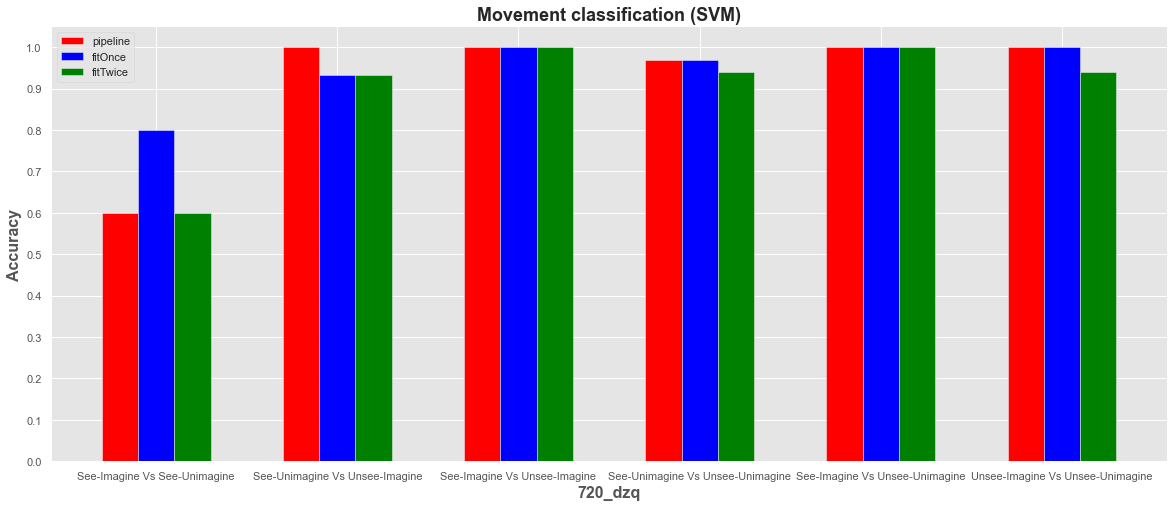

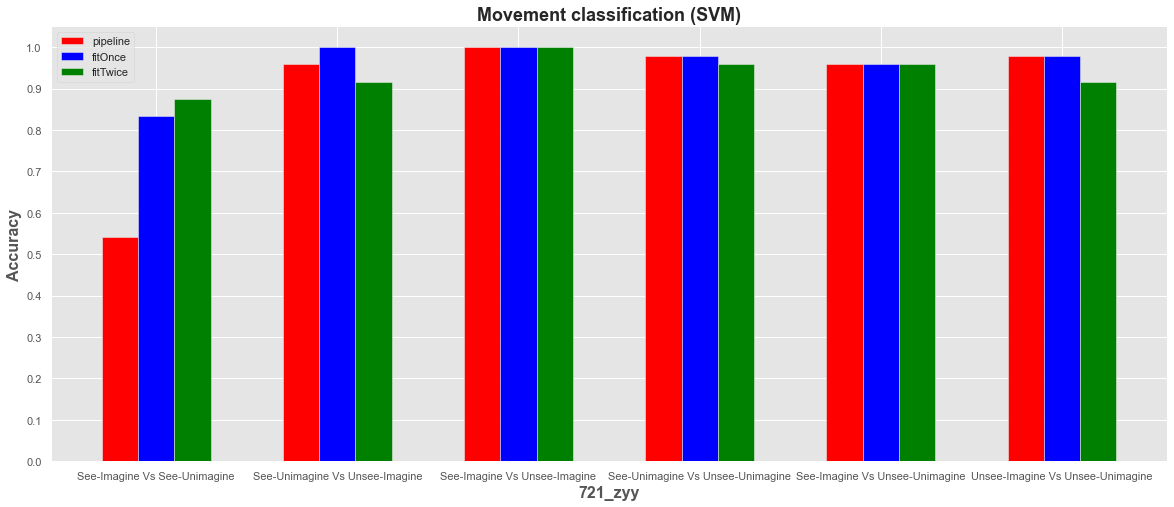

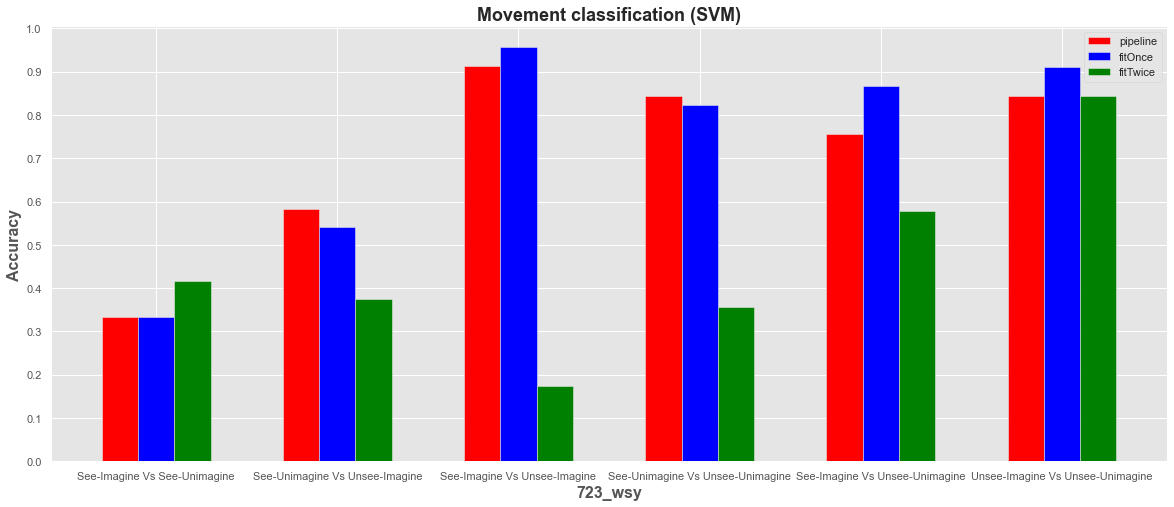

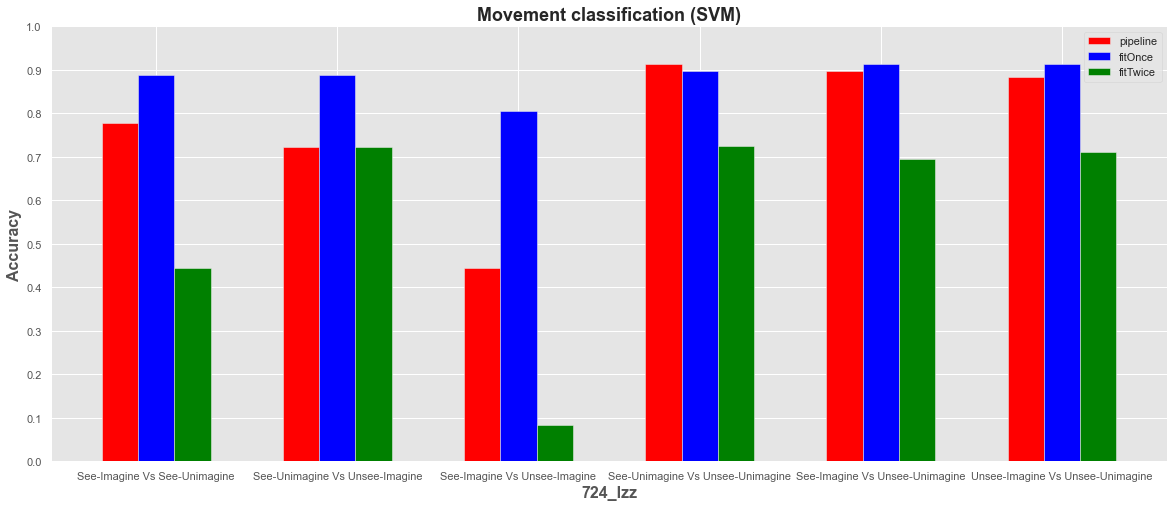

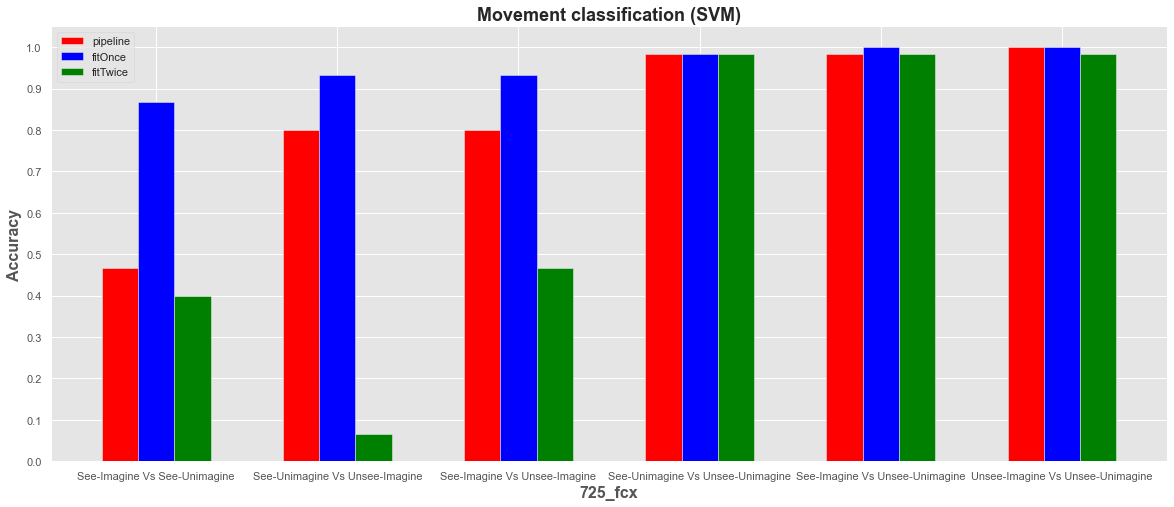

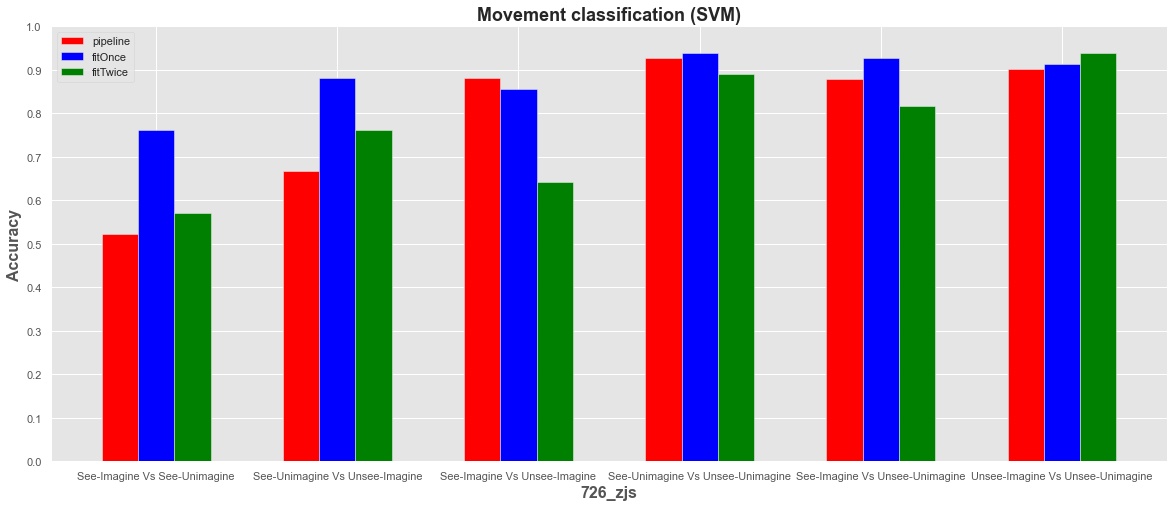

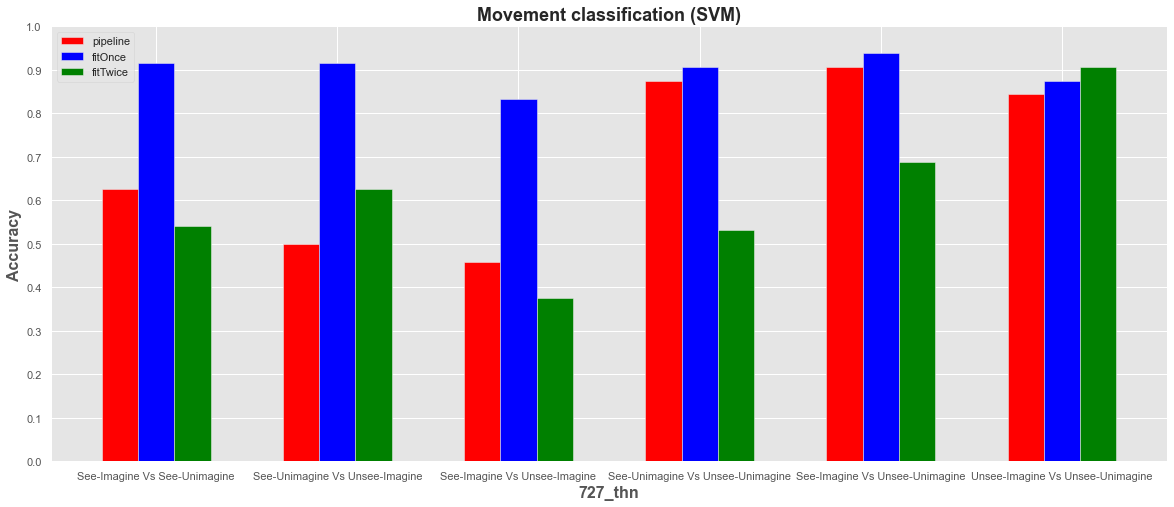

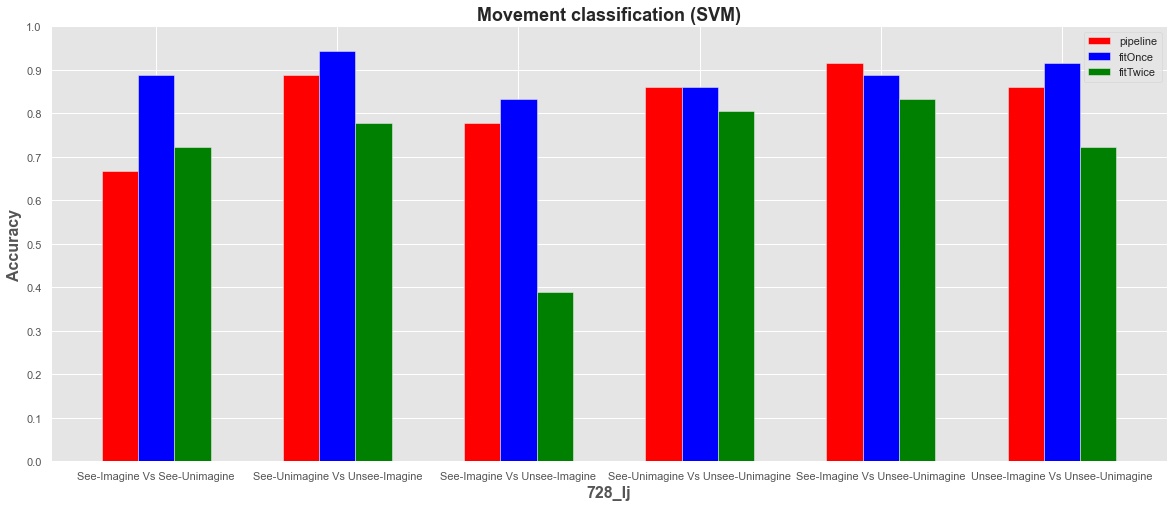

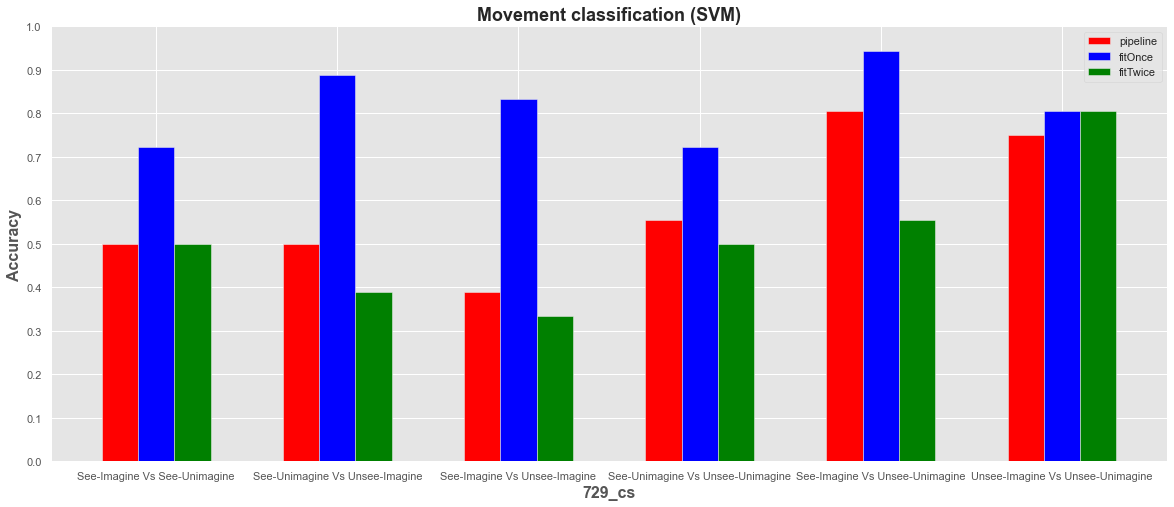

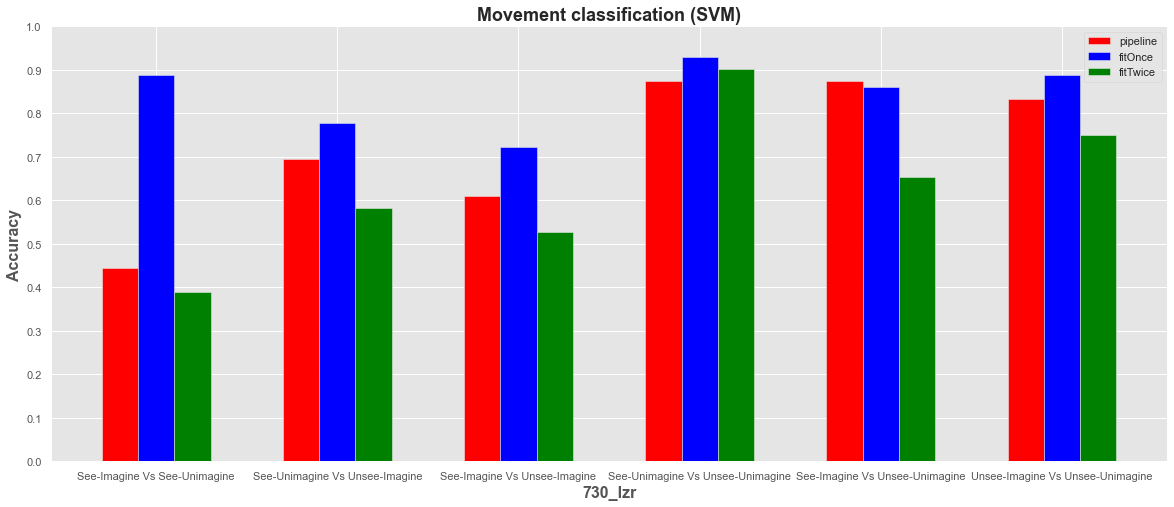

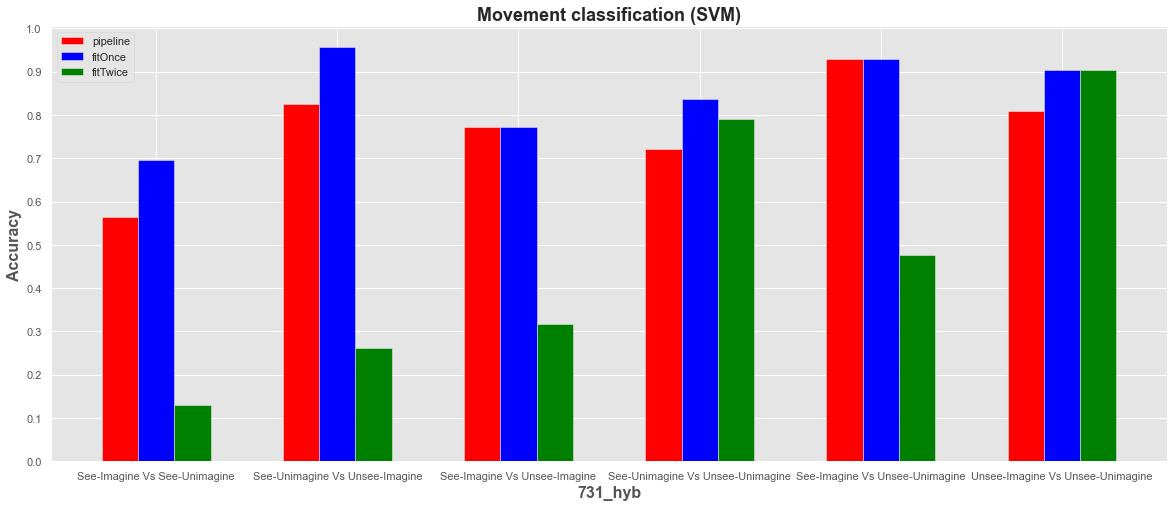

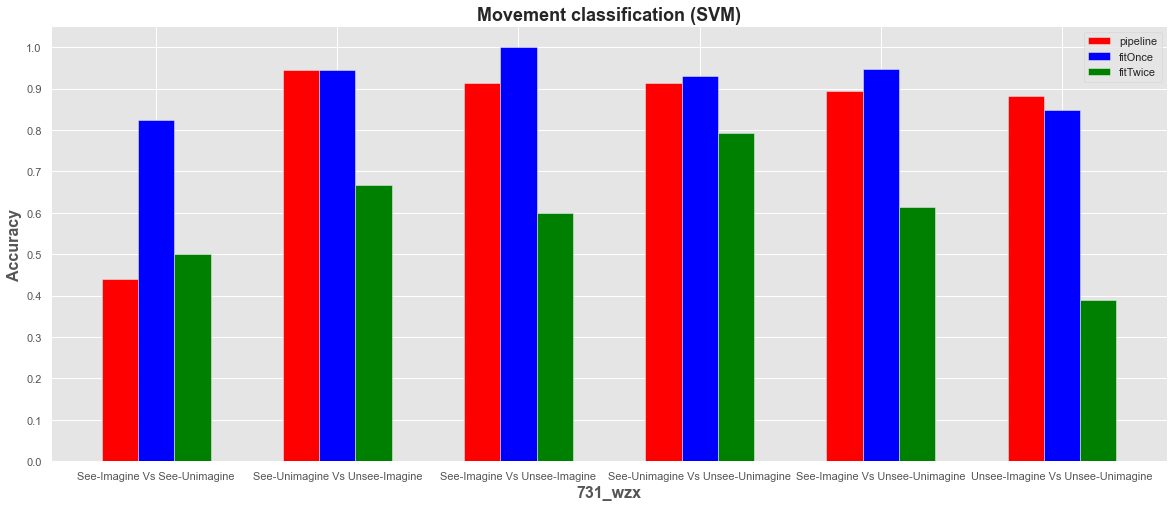

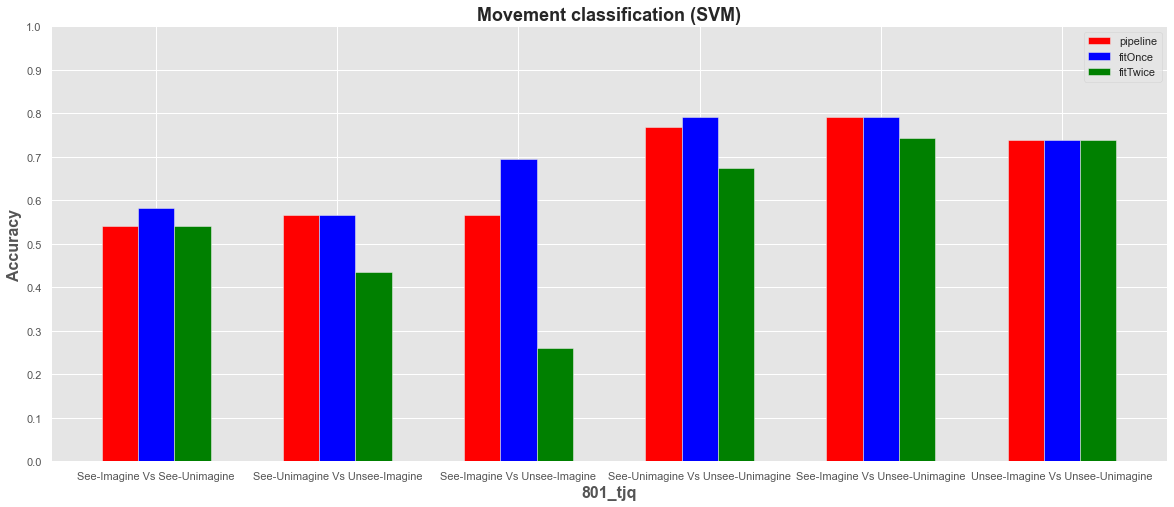

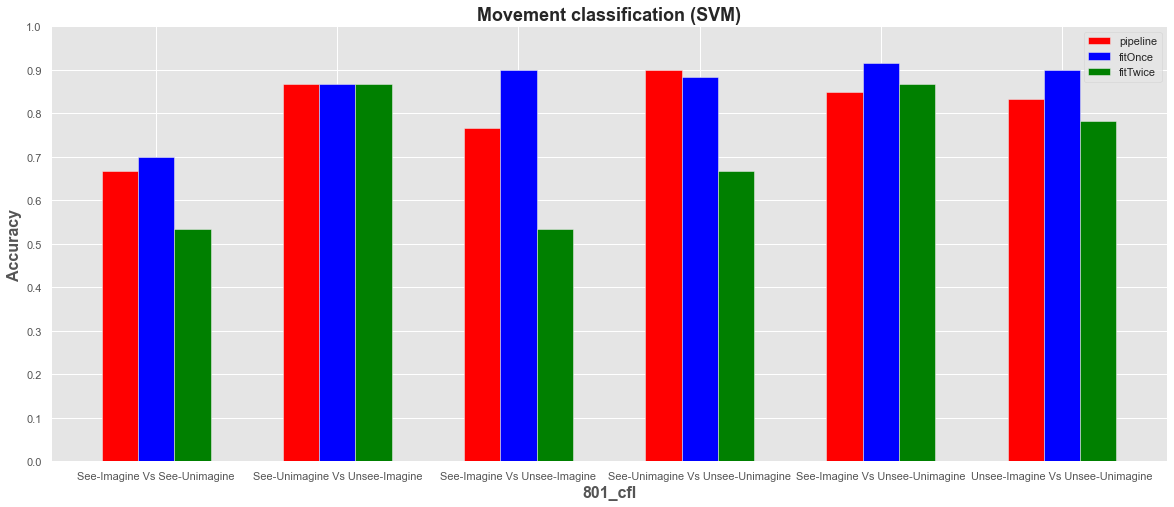

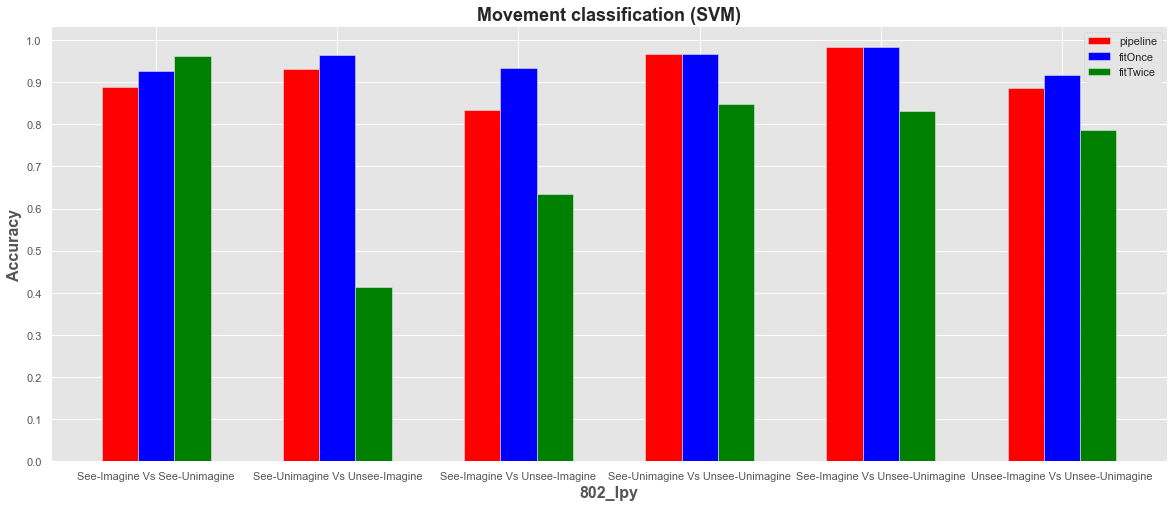

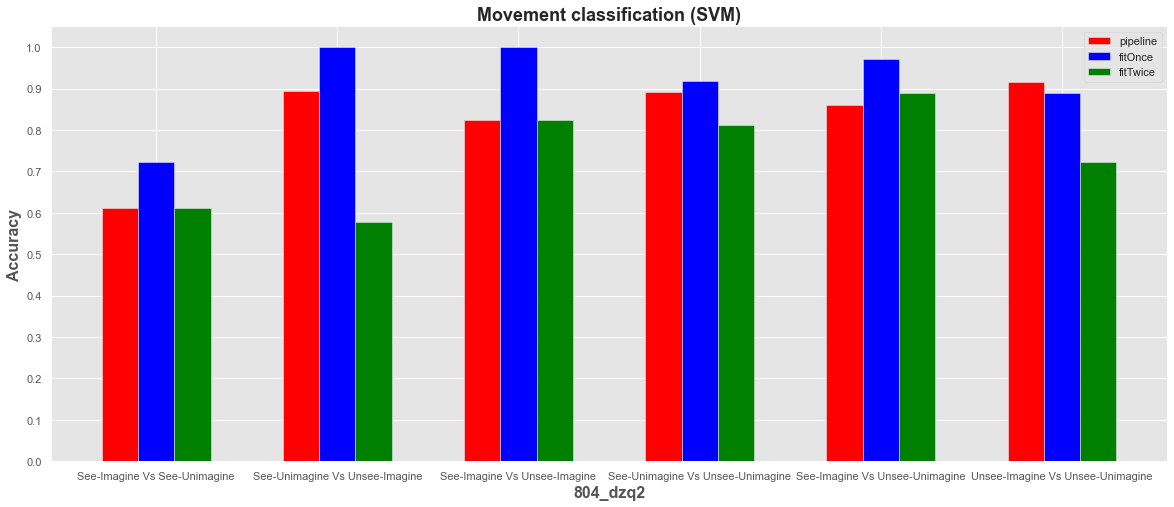

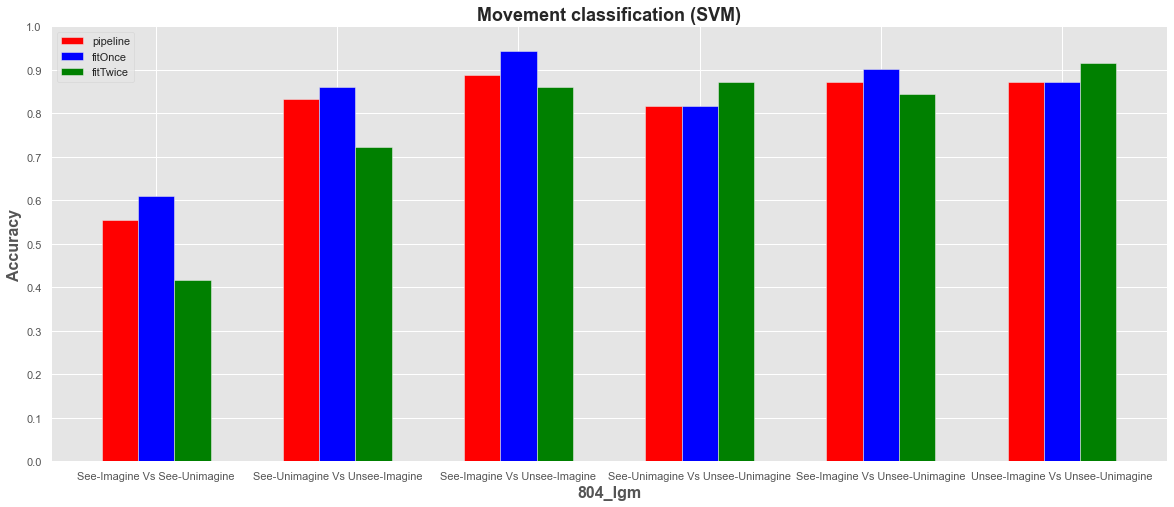

In [37]:
%matplotlib inline
for i in range(len(persons)):
    person = persons[i]
    num = nums[i]
    date = dates[i]
    raw = []
    # import data
    for j in range(num):
        f = "E:\大创\data\EEG/0{}{}_eyesImagine{}-edf-pre.edf".format(date, person, j + 1)
        raw_files = read_raw_edf(f, preload=True, stim_channel='auto')
        raw.append(raw_files)
    # data preprocess
    raw = concatenate_raws(raw)
    events, event_dict = mne.events_from_annotations(raw)
    subkey = ['S  1','S  2','S  3','S 10']
    event_ids = dict([(key, event_dict[key]) for key in subkey])
    event_id_compose = [{'S  1':event_ids['S  1'], 'S  2':event_ids['S  2']},
                {'S  1':event_ids['S  1'], 'S  3':event_ids['S  3']},
                {'S  2':event_ids['S  2'], 'S  3':event_ids['S  3']},
                {'S  1':event_ids['S  1'], 'S 10':event_ids['S 10']},
                {'S  2':event_ids['S  2'], 'S 10':event_ids['S 10']},
                {'S  3':event_ids['S  3'], 'S 10':event_ids['S 10']}]
    acc = []
    # model train&fit&predict
    for event_id in event_id_compose:
#         print(event_id)
        tmin, tmax = -0.5, 4.5
        picks = pick_types(raw.info, meg=False, eeg=True, stim=True, eog=False)
        epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
        epochs_data = epochs.get_data()
        labels = epochs.events[:, -1]
        temp = labels.min()
        labels = labels - temp

        acc.append(csp_svm_pipeline(epochs_data, labels))
        acc.append(csp_svm_fitOnce(epochs_data, labels))
        acc.append(csp_svm_fitTwice(epochs_data, labels))
#         print(acc)
    # result visualization
    plt.style.use("ggplot")
    states = ["See-Imagine Vs See-Unimagine", "See-Unimagine Vs Unsee-Imagine","See-Imagine Vs Unsee-Imagine",\
             "See-Unimagine Vs Unsee-Unimagine","See-Imagine Vs Unsee-Unimagine","Unsee-Imagine Vs Unsee-Unimagine"]
    linear = acc[::3]
    rbf = acc[1::3]
    sigmoid = acc[2::3]
    xticks = np.arange(len(states))
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.bar(xticks, linear, width=0.2, label="pipeline", color="red")
    ax.bar(xticks + 0.2, rbf, width=0.2, label="fitOnce", color="blue")
    ax.bar(xticks + 0.4, sigmoid, width=0.2, label="fitTwice", color="green")
    ax.set_title("Movement classification (SVM)", fontsize=18, fontweight='heavy')
    ax.set_xlabel("{}_{}".format(date,person), fontsize=16, fontweight='heavy')
    ax.set_ylabel("Accuracy", fontsize=16, fontweight='heavy')
    plt.yticks(np.arange(0, 1.1, 0.1))
    ax.legend()
    # 最后调整x轴标签的位置
    ax.set_xticks(xticks + 0.2)
    ax.set_xticklabels(states)
    plt.savefig("E:/大创/result_脑电/newRaw_{}_{}".format(date,person), bbox_inches='tight')
    print('i = {} -- done'.format(i))

# ##############################################################

[0.9350989988164924]
[0.9350989988164924, 0.9192975722099607]
[0.9350989988164924, 0.9192975722099607, 0.9161566142773659]
[0.9350989988164924, 0.9192975722099607, 0.9161566142773659, 0.9416529684422528]
[0.9350989988164924, 0.9192975722099607, 0.9161566142773659, 0.9416529684422528, 0.9403297566082177]
[0.9350989988164924, 0.9192975722099607, 0.9161566142773659, 0.9416529684422528, 0.9403297566082177, 0.8988484689871762]
i = 0 -- done
[0.9319472211115554]
[0.9319472211115554, 0.9066973210715714]
[0.9319472211115554, 0.9066973210715714, 0.9033386645341863]
[0.9319472211115554, 0.9066973210715714, 0.9033386645341863, 0.9088769300407383]
[0.9319472211115554, 0.9066973210715714, 0.9033386645341863, 0.9088769300407383, 0.9060906301865915]
[0.9319472211115554, 0.9066973210715714, 0.9033386645341863, 0.9088769300407383, 0.9060906301865915, 0.8886184177438012]
i = 1 -- done
[0.9742029286530273]
[0.9742029286530273, 0.9651261813272406]
[0.9742029286530273, 0.9651261813272406, 0.967339380037458

<ipython-input-37-1b10e28ec49c>:10: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw_files = read_raw_edf(f, preload=True, stim_channel='auto')


[0.8786479298447384]
[0.8786479298447384, 0.9018892443022791]
[0.8786479298447384, 0.9018892443022791, 0.8794888705688376]
[0.8786479298447384, 0.9018892443022791, 0.8794888705688376, 0.88739706702536]
[0.8786479298447384, 0.9018892443022791, 0.8794888705688376, 0.88739706702536, 0.866820618691299]
[0.8786479298447384, 0.9018892443022791, 0.8794888705688376, 0.88739706702536, 0.866820618691299, 0.8453744701637175]
i = 14 -- done
[0.9627615620418499]
[0.9627615620418499, 0.9460423166671036]
[0.9627615620418499, 0.9460423166671036, 0.9570502195469481]
[0.9627615620418499, 0.9460423166671036, 0.9570502195469481, 0.9624216576079889]
[0.9627615620418499, 0.9460423166671036, 0.9570502195469481, 0.9624216576079889, 0.9566536805413164]
[0.9627615620418499, 0.9460423166671036, 0.9570502195469481, 0.9624216576079889, 0.9566536805413164, 0.9268772024939008]
i = 15 -- done
[0.914272160477094]
[0.914272160477094, 0.9087693141772838]
[0.914272160477094, 0.9087693141772838, 0.9103292016526723]
[0.914

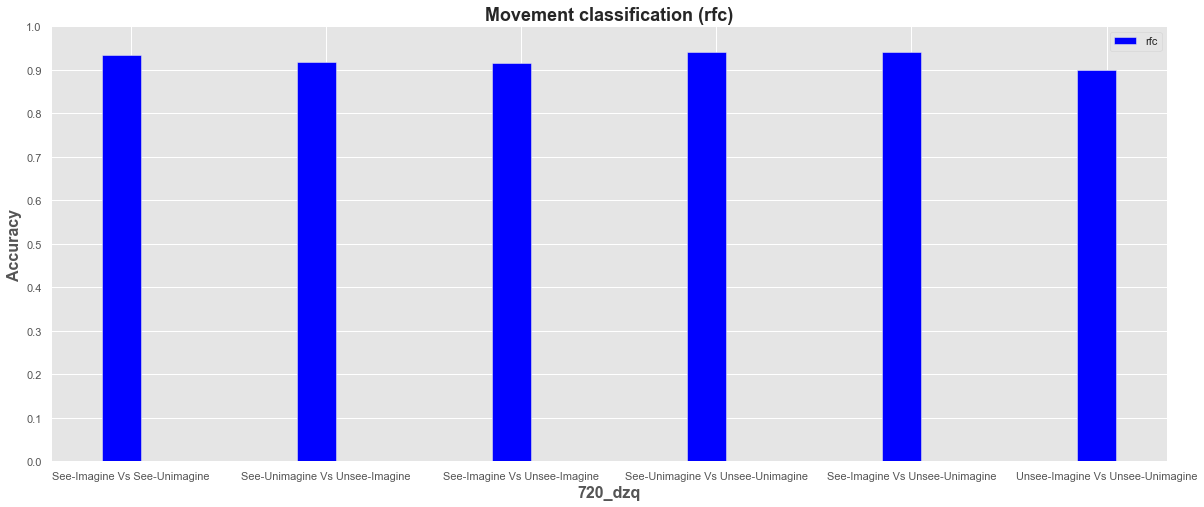

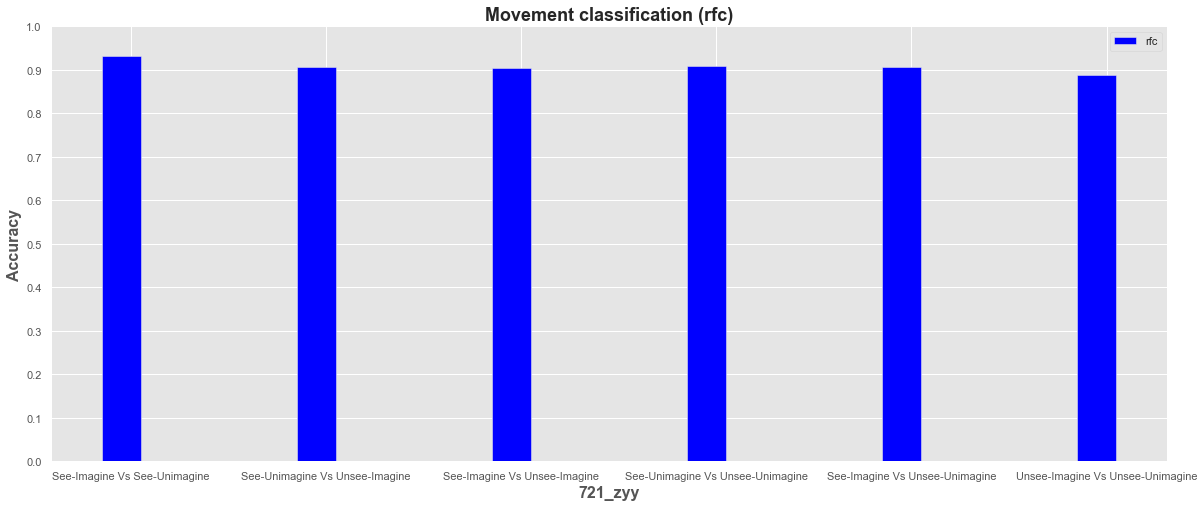

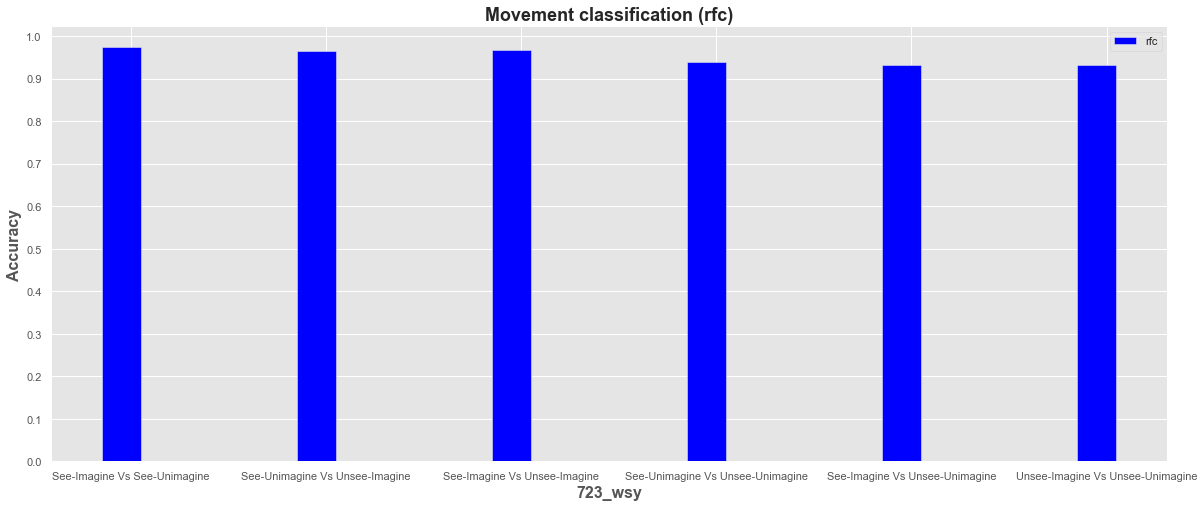

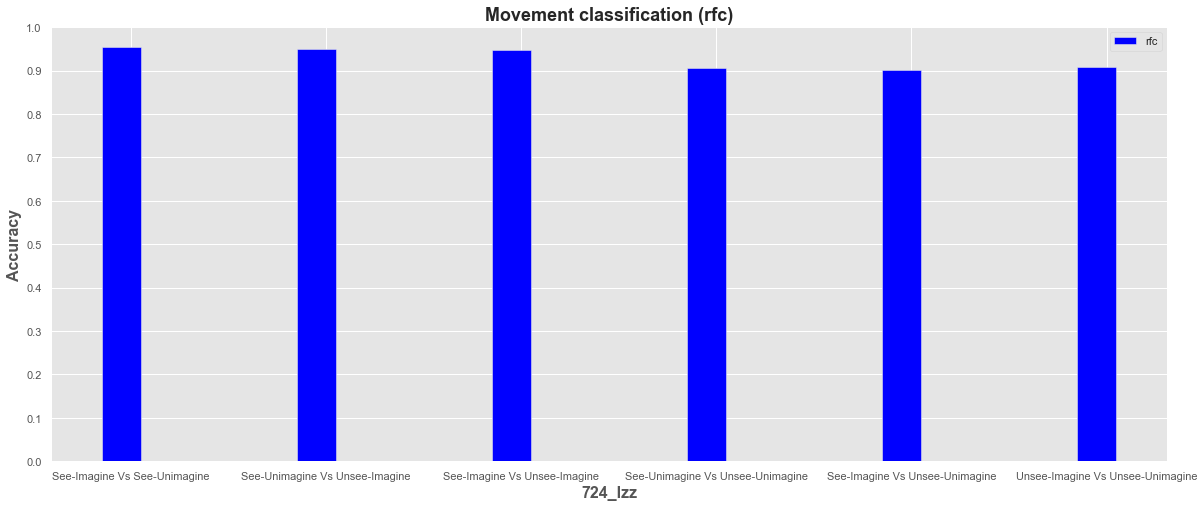

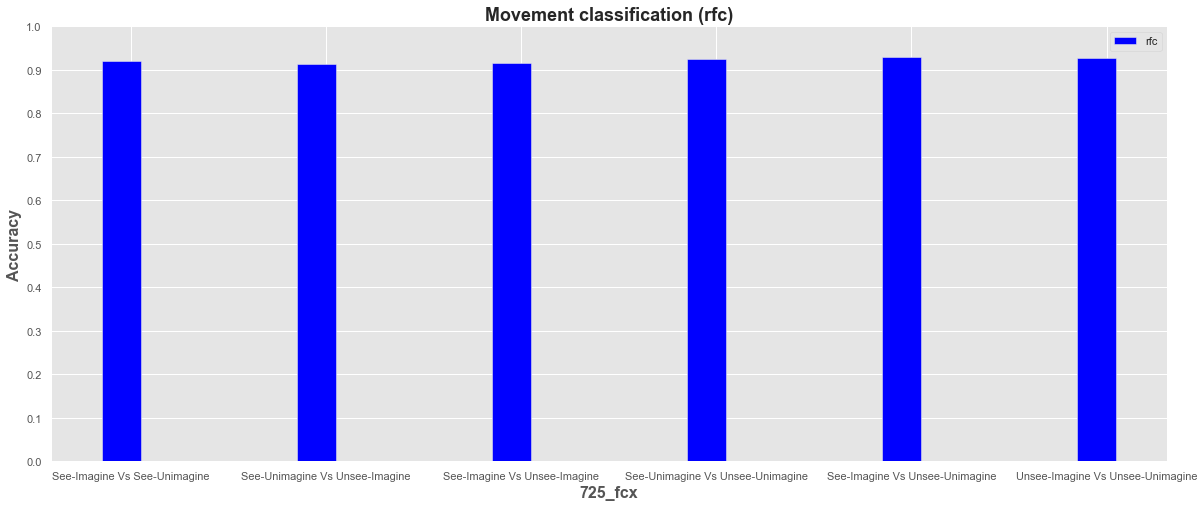

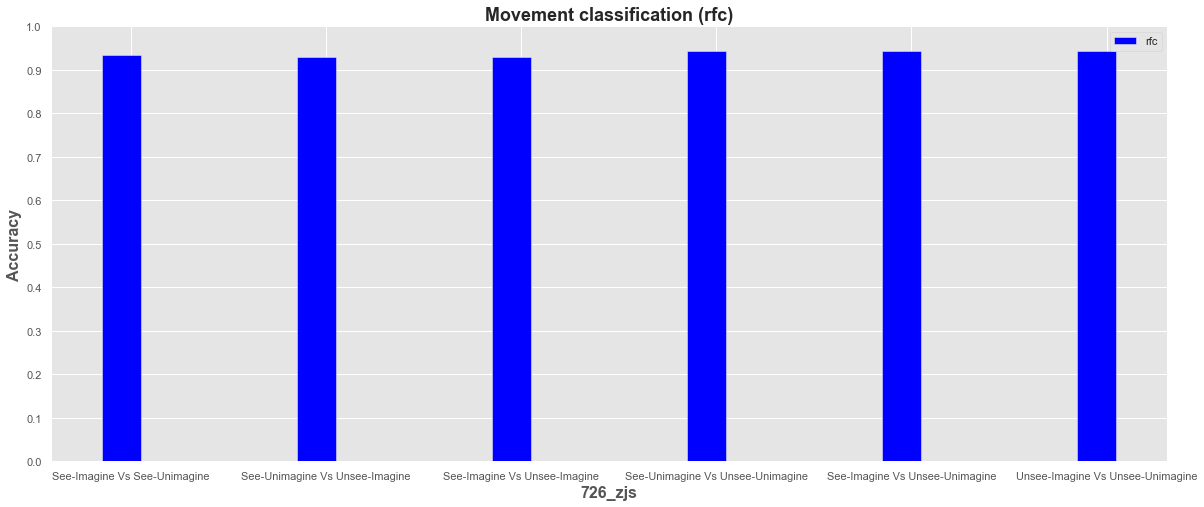

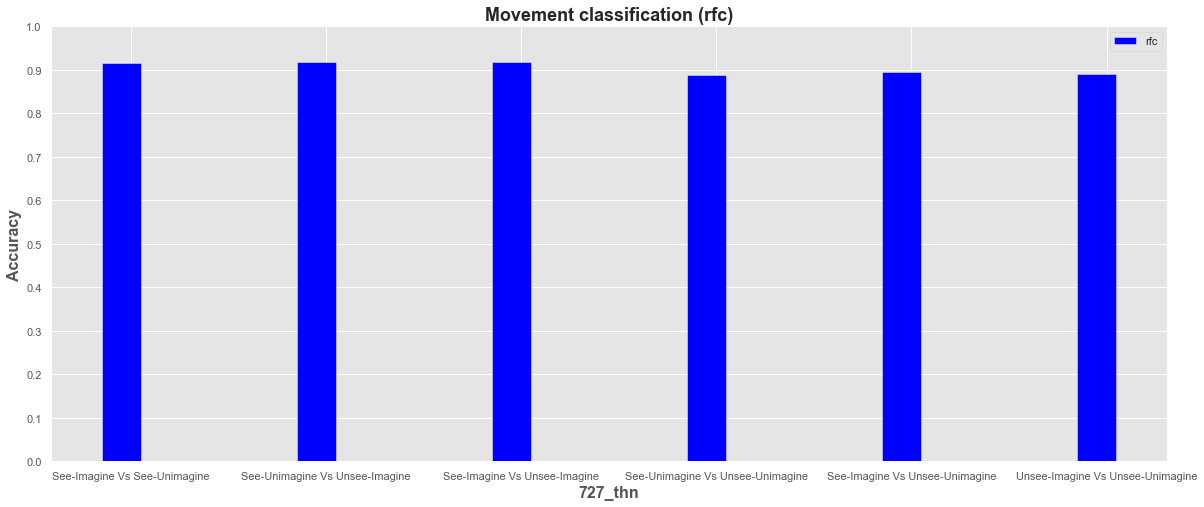

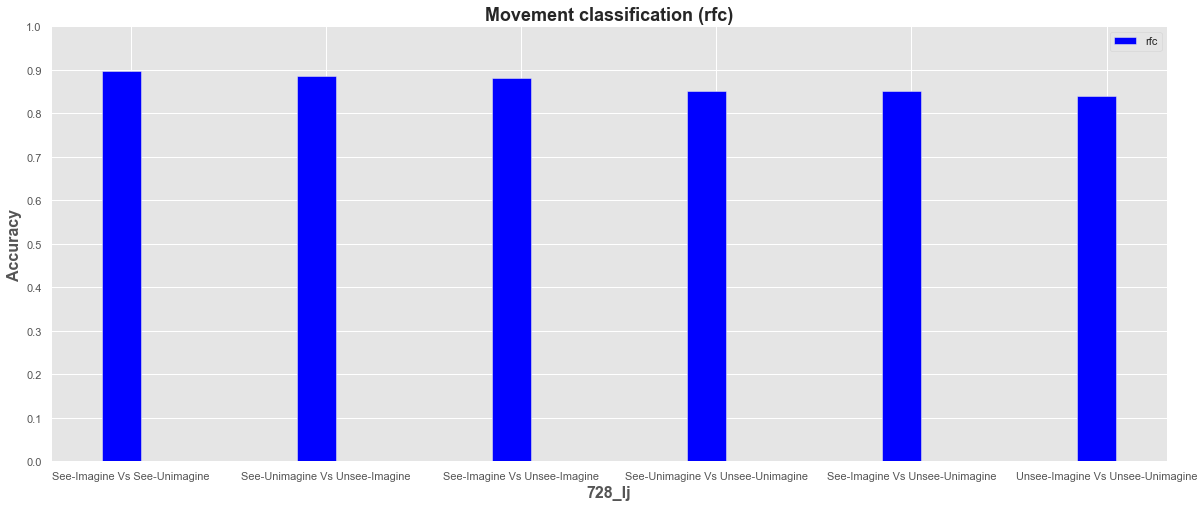

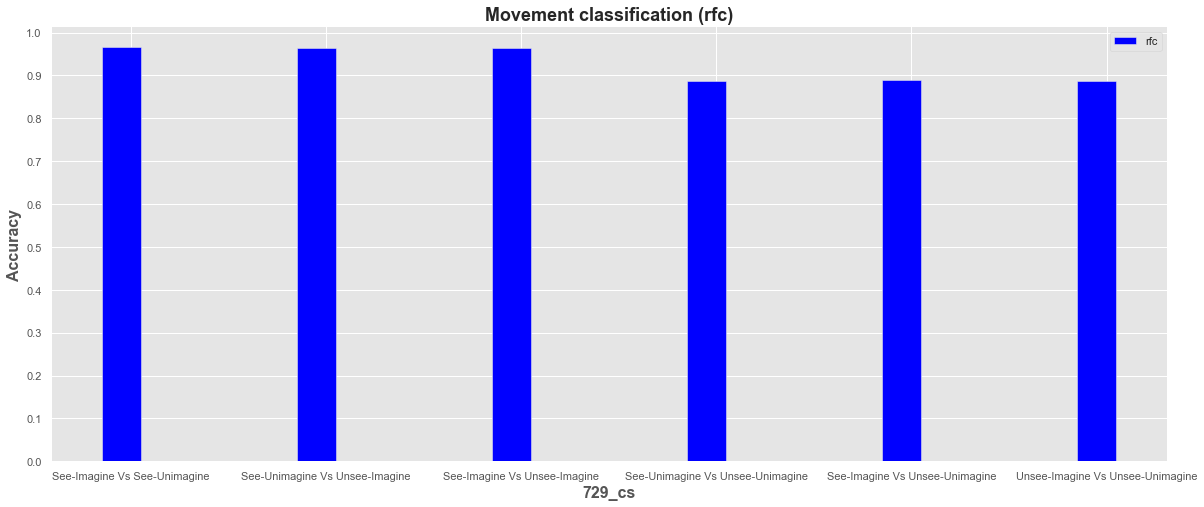

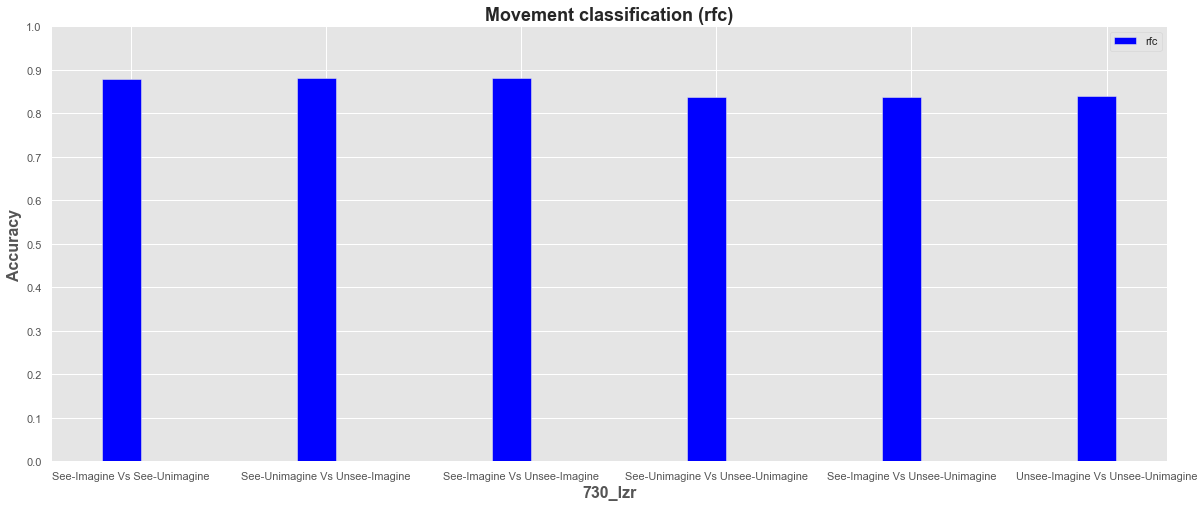

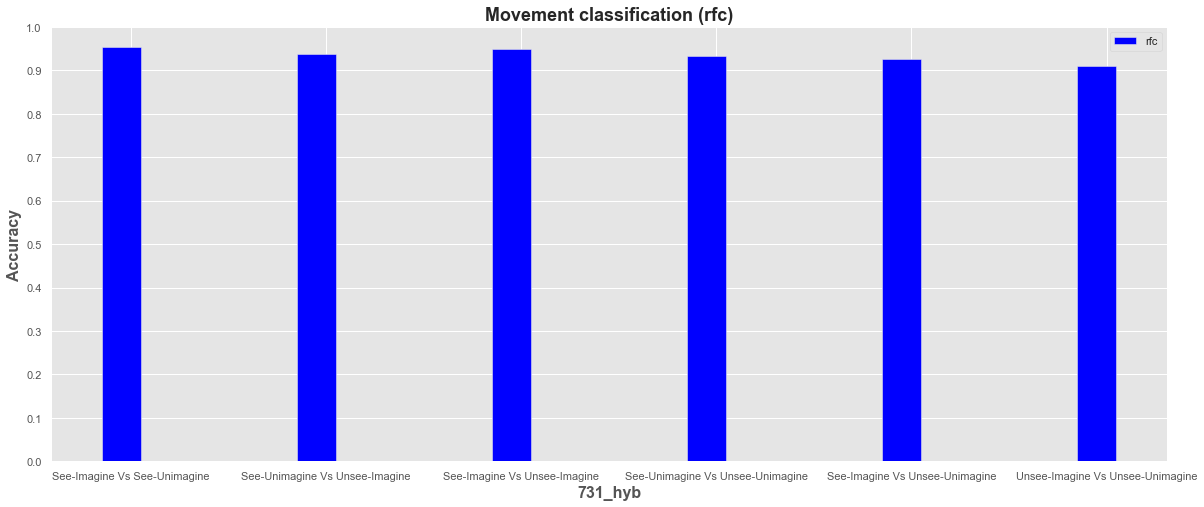

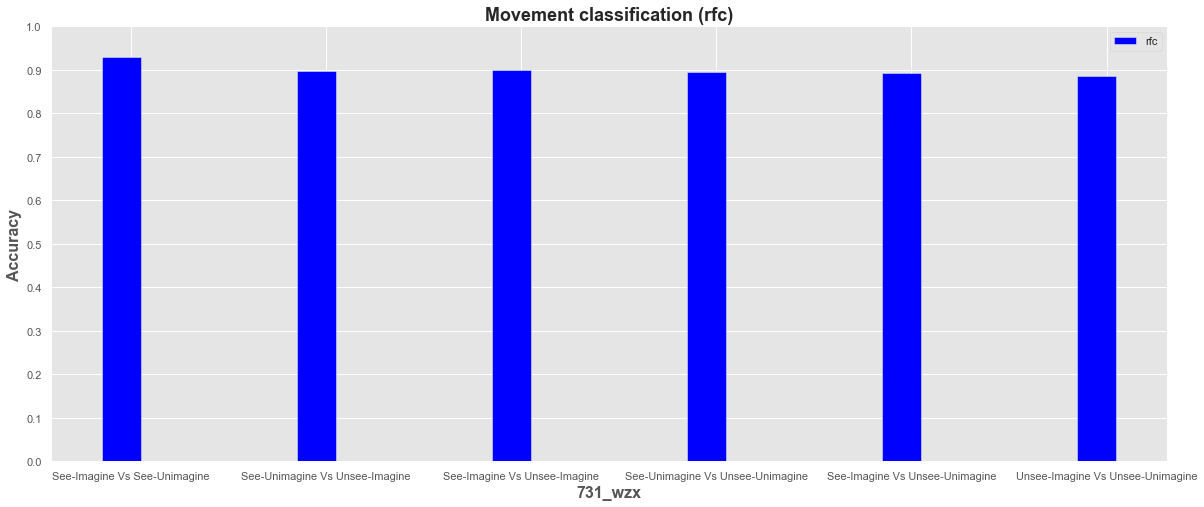

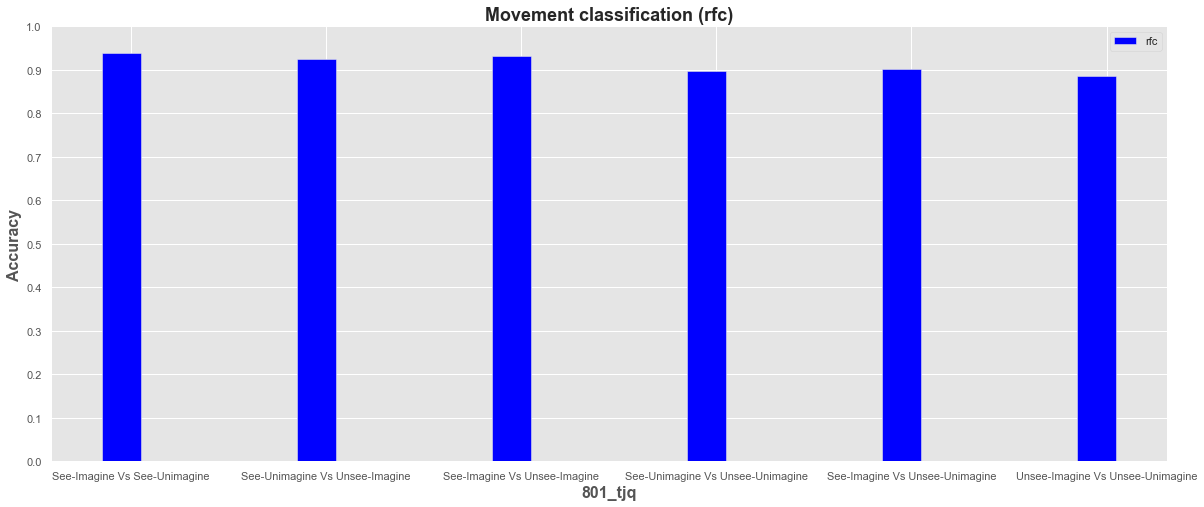

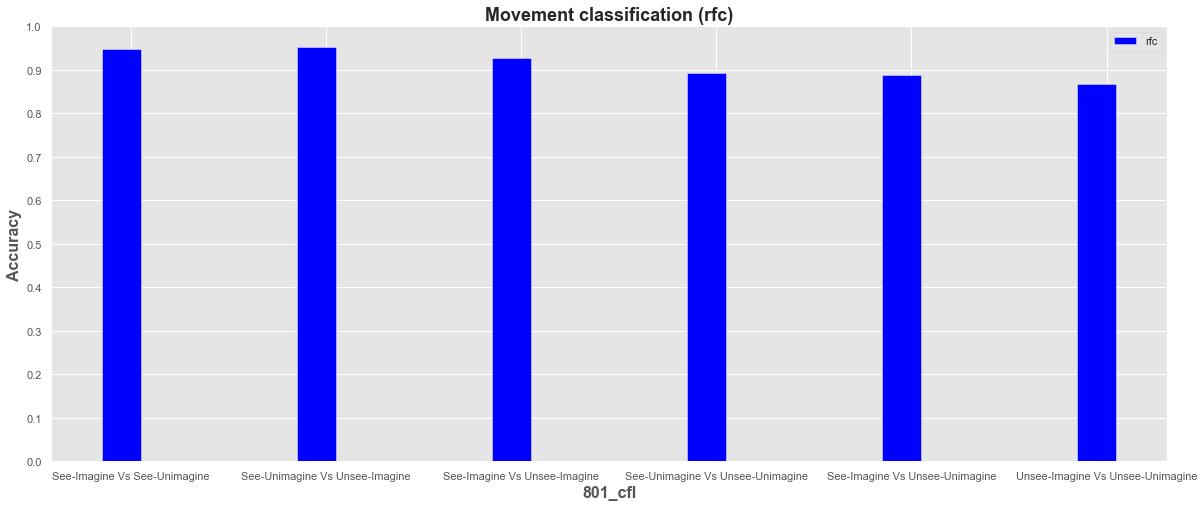

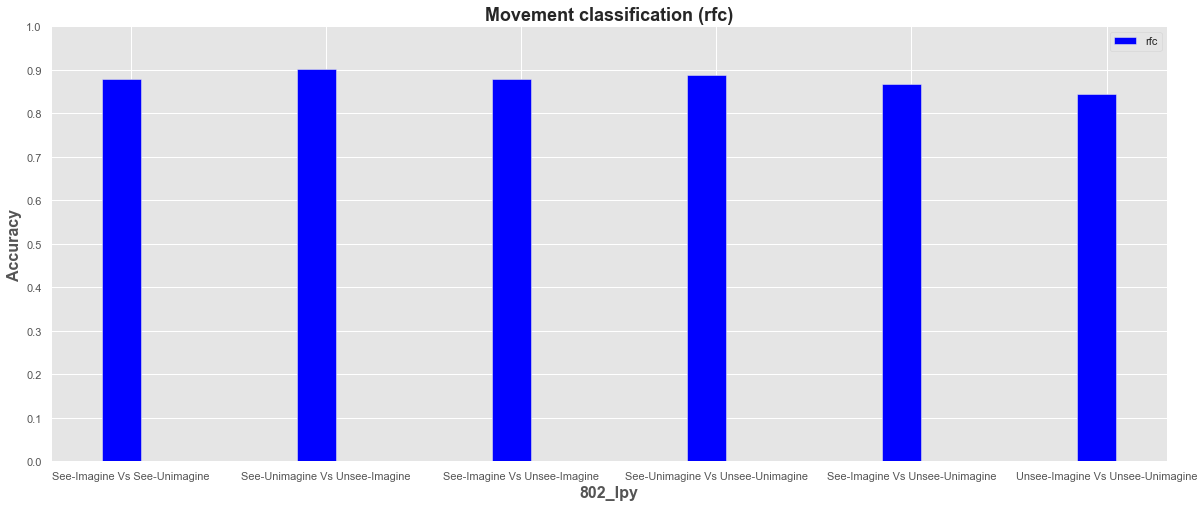

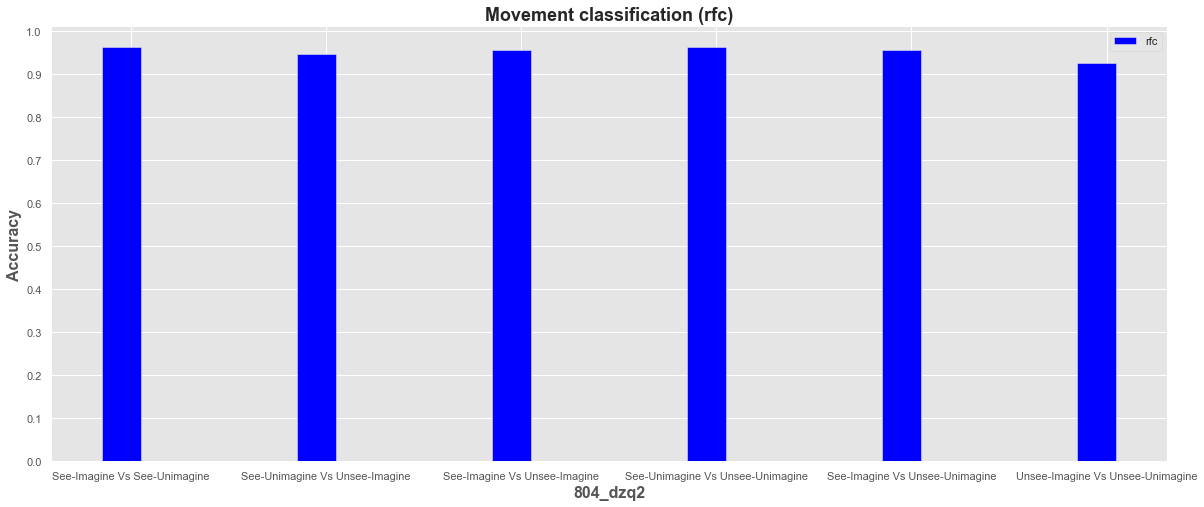

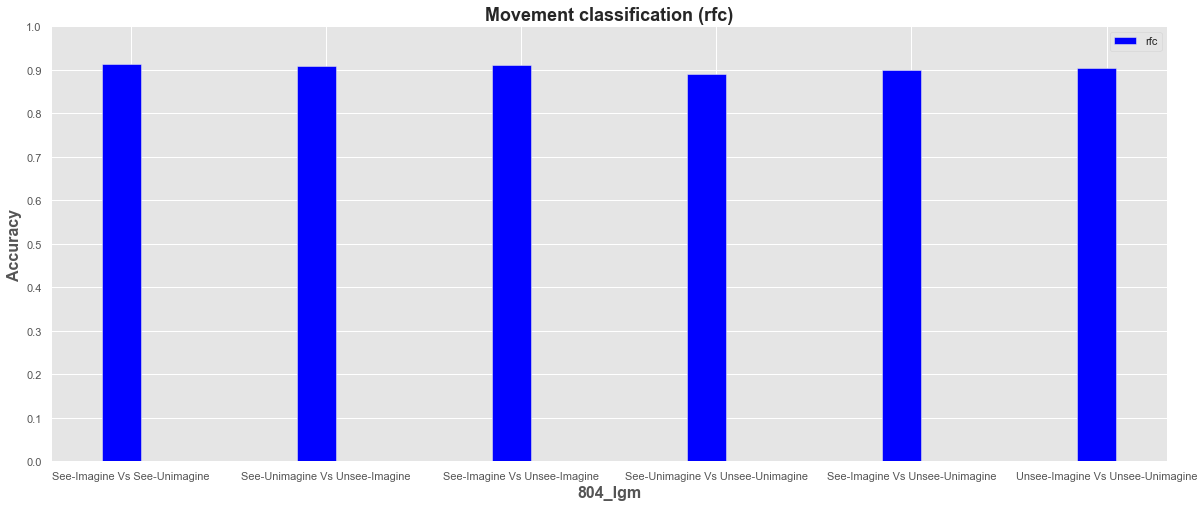

In [37]:
%matplotlib inline
for i in range(len(persons)):
    person = persons[i]
    num = nums[i]
    date = dates[i]
    raw = []
    # import data
    for j in range(num):
        f = "E:\大创\data\EEG/0{}{}_eyesImagine{}-edf-pre.edf".format(date, person, j + 1)
        raw_files = read_raw_edf(f, preload=True, stim_channel='auto')
        raw.append(raw_files)
    # data preprocess
    raw = concatenate_raws(raw)
    events, event_dict = mne.events_from_annotations(raw)
    subkey = ['S  1','S  2','S  3','S 10']
    event_ids = dict([(key, event_dict[key]) for key in subkey])
    event_id_compose = [{'S  1':event_ids['S  1'], 'S  2':event_ids['S  2']},
                {'S  1':event_ids['S  1'], 'S  3':event_ids['S  3']},
                {'S  2':event_ids['S  2'], 'S  3':event_ids['S  3']},
                {'S  1':event_ids['S  1'], 'S 10':event_ids['S 10']},
                {'S  2':event_ids['S  2'], 'S 10':event_ids['S 10']},
                {'S  3':event_ids['S  3'], 'S 10':event_ids['S 10']}]
    acc = []
    # model train & fit & predict
    for event_id in event_id_compose:
        tmin, tmax = -0.5, 4.5
        picks = pick_types(raw.info, meg=False, eeg=True, stim=True, eog=False)
        epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
        epochs_data = epochs.get_data()
        labels = epochs.events[:, -1]
        temp = labels.min()
        labels = labels - temp
        data = pd.DataFrame(columns=[*np.arange(0, len(epochs_data[0])), 'label'])
        for k in range(len(epochs_data)):
            tmp = pd.DataFrame(epochs_data[k]).transpose()
            tmp['label'] = labels[k]
            data = pd.concat([data, tmp], axis=0)

        acc.append(rfc(data))
        print(acc)
#         acc.append(svm(data))
#         print(acc)

    # result visualization
    plt.style.use("ggplot")
    states = ["See-Imagine Vs See-Unimagine", "See-Unimagine Vs Unsee-Imagine","See-Imagine Vs Unsee-Imagine",\
             "See-Unimagine Vs Unsee-Unimagine","See-Imagine Vs Unsee-Unimagine","Unsee-Imagine Vs Unsee-Unimagine"]
#     rfc_r = acc[::2]
#     svm_r = acc[1::2]
    xticks = np.arange(len(states))
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.bar(xticks, acc, width=0.2, label="rfc", color="blue")
#     ax.bar(xticks + 0.2, svm_r, width=0.2, label="svm", color="blue")
    ax.set_title("Movement classification (rfc)", fontsize=18, fontweight='heavy')
    ax.set_xlabel("{}_{}".format(date,person), fontsize=16, fontweight='heavy')
    ax.set_ylabel("Accuracy", fontsize=16, fontweight='heavy')
    plt.yticks(np.arange(0, 1.1, 0.1))
    ax.legend()
    # 最后调整x轴标签的位置
    ax.set_xticks(xticks + 0.05)
    ax.set_xticklabels(states)
    plt.savefig("E:/大创/result_脑电/flatted_{}_{}".format(date,person), bbox_inches='tight')
    print('i = {} -- done'.format(i))

# ##############################################################

[0.6133333333333333]
[0.6133333333333333, 0.5333333333333333]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333, 0.9066666666666666]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333, 0.9066666666666666, 1.0]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333, 0.9066666666666666, 1.0, 1.0]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333, 0.9066666666666666, 1.0, 1.0, 0.9358974358974359]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333, 0.9066666666666666, 1.0, 1.0, 0.9358974358974359, 0.96875]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333, 0.9066666666666666, 1.0, 1.0, 0.9358974358974359, 0.96875, 1.0]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333, 0.9066666666666666, 1.0, 1.0, 0.9358974358974359, 0.96875, 1.0, 0.8333333333333334]
[0.6133333333333333, 0.5333333333333333, 0.7333333333333333, 0.9066666666666666, 1.0, 1.0, 0.9358974358974359, 0.96875

[0.5948275862068966, 0.574468085106383, 0.5416666666666666, 0.7586206896551724, 0.6595744680851063, 0.75, 0.8421052631578947, 0.8260869565217391, 0.6956521739130435, 0.78125, 0.7777777777777778, 0.7333333333333333, 0.8108108108108109, 0.7865168539325843, 0.8, 0.7927927927927928, 0.7865168539325843, 0.8444444444444444]
i = 2 -- done
[0.6222222222222222]
[0.6222222222222222, 0.6388888888888888]
[0.6222222222222222, 0.6388888888888888, 0.8333333333333334]
[0.6222222222222222, 0.6388888888888888, 0.8333333333333334, 0.6666666666666666]
[0.6222222222222222, 0.6388888888888888, 0.8333333333333334, 0.6666666666666666, 0.6666666666666666]
[0.6222222222222222, 0.6388888888888888, 0.8333333333333334, 0.6666666666666666, 0.6666666666666666, 0.5833333333333334]
[0.6222222222222222, 0.6388888888888888, 0.8333333333333334, 0.6666666666666666, 0.6666666666666666, 0.5833333333333334, 0.6111111111111112]
[0.6222222222222222, 0.6388888888888888, 0.8333333333333334, 0.6666666666666666, 0.6666666666666666

[0.5714285714285714, 0.5595238095238095, 0.5476190476190477, 0.722488038277512, 0.7261904761904762, 0.7380952380952381, 0.6842105263157895, 0.5952380952380952, 0.8571428571428571, 0.8501228501228502, 0.8895705521472392, 0.9024390243902439, 0.8697788697788698]
[0.5714285714285714, 0.5595238095238095, 0.5476190476190477, 0.722488038277512, 0.7261904761904762, 0.7380952380952381, 0.6842105263157895, 0.5952380952380952, 0.8571428571428571, 0.8501228501228502, 0.8895705521472392, 0.9024390243902439, 0.8697788697788698, 0.8588957055214724]
[0.5714285714285714, 0.5595238095238095, 0.5476190476190477, 0.722488038277512, 0.7261904761904762, 0.7380952380952381, 0.6842105263157895, 0.5952380952380952, 0.8571428571428571, 0.8501228501228502, 0.8895705521472392, 0.9024390243902439, 0.8697788697788698, 0.8588957055214724, 0.9146341463414634]
[0.5714285714285714, 0.5595238095238095, 0.5476190476190477, 0.722488038277512, 0.7261904761904762, 0.7380952380952381, 0.6842105263157895, 0.5952380952380952, 

[0.5, 0.5, 0.3888888888888889, 0.7333333333333333, 0.6666666666666666, 0.5555555555555556, 0.7222222222222222, 0.7777777777777778, 0.3333333333333333, 0.7944444444444444, 0.6666666666666666, 0.6111111111111112, 0.7555555555555555]
[0.5, 0.5, 0.3888888888888889, 0.7333333333333333, 0.6666666666666666, 0.5555555555555556, 0.7222222222222222, 0.7777777777777778, 0.3333333333333333, 0.7944444444444444, 0.6666666666666666, 0.6111111111111112, 0.7555555555555555, 0.75]
[0.5, 0.5, 0.3888888888888889, 0.7333333333333333, 0.6666666666666666, 0.5555555555555556, 0.7222222222222222, 0.7777777777777778, 0.3333333333333333, 0.7944444444444444, 0.6666666666666666, 0.6111111111111112, 0.7555555555555555, 0.75, 0.75]
[0.5, 0.5, 0.3888888888888889, 0.7333333333333333, 0.6666666666666666, 0.5555555555555556, 0.7222222222222222, 0.7777777777777778, 0.3333333333333333, 0.7944444444444444, 0.6666666666666666, 0.6111111111111112, 0.7555555555555555, 0.75, 0.75, 0.7111111111111111]
[0.5, 0.5, 0.3888888888888

[0.5882352941176471, 0.6029411764705882, 0.38235294117647056, 0.8238636363636364]
[0.5882352941176471, 0.6029411764705882, 0.38235294117647056, 0.8238636363636364, 0.9014084507042254]
[0.5882352941176471, 0.6029411764705882, 0.38235294117647056, 0.8238636363636364, 0.9014084507042254, 0.9444444444444444]
[0.5882352941176471, 0.6029411764705882, 0.38235294117647056, 0.8238636363636364, 0.9014084507042254, 0.9444444444444444, 0.8304093567251462]
[0.5882352941176471, 0.6029411764705882, 0.38235294117647056, 0.8238636363636364, 0.9014084507042254, 0.9444444444444444, 0.8304093567251462, 0.927536231884058]
[0.5882352941176471, 0.6029411764705882, 0.38235294117647056, 0.8238636363636364, 0.9014084507042254, 0.9444444444444444, 0.8304093567251462, 0.927536231884058, 0.9142857142857143]
[0.5882352941176471, 0.6029411764705882, 0.38235294117647056, 0.8238636363636364, 0.9014084507042254, 0.9444444444444444, 0.8304093567251462, 0.927536231884058, 0.9142857142857143, 0.8344827586206897]
[0.588235

[0.64, 0.7166666666666667, 0.7, 0.84, 0.9333333333333333, 0.8333333333333334, 0.78, 0.8333333333333334, 0.8, 0.8233333333333334, 0.8583333333333333, 0.9333333333333333, 0.7966666666666666, 0.8916666666666667, 0.8833333333333333, 0.7766666666666666, 0.8]
[0.64, 0.7166666666666667, 0.7, 0.84, 0.9333333333333333, 0.8333333333333334, 0.78, 0.8333333333333334, 0.8, 0.8233333333333334, 0.8583333333333333, 0.9333333333333333, 0.7966666666666666, 0.8916666666666667, 0.8833333333333333, 0.7766666666666666, 0.8, 0.85]
i = 13 -- done


<ipython-input-134-83217da2330a>:11: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw_files = read_raw_edf(f, preload=True, stim_channel='auto')


[0.9029850746268657]
[0.9029850746268657, 0.9259259259259259]
[0.9029850746268657, 0.9259259259259259, 0.9629629629629629]
[0.9029850746268657, 0.9259259259259259, 0.9629629629629629, 0.9861111111111112]
[0.9029850746268657, 0.9259259259259259, 0.9629629629629629, 0.9861111111111112, 0.9482758620689655]
[0.9029850746268657, 0.9259259259259259, 0.9629629629629629, 0.9861111111111112, 0.9482758620689655, 0.9310344827586207]
[0.9029850746268657, 0.9259259259259259, 0.9629629629629629, 0.9861111111111112, 0.9482758620689655, 0.9310344827586207, 0.8424657534246576]
[0.9029850746268657, 0.9259259259259259, 0.9629629629629629, 0.9861111111111112, 0.9482758620689655, 0.9310344827586207, 0.8424657534246576, 0.8305084745762712]
[0.9029850746268657, 0.9259259259259259, 0.9629629629629629, 0.9861111111111112, 0.9482758620689655, 0.9310344827586207, 0.8424657534246576, 0.8305084745762712, 0.9333333333333333]
[0.9029850746268657, 0.9259259259259259, 0.9629629629629629, 0.9861111111111112, 0.94827586

[0.6214689265536724, 0.5352112676056338, 0.5277777777777778, 0.7344632768361582, 0.8732394366197183, 0.8888888888888888, 0.8, 0.875, 0.9444444444444444, 0.7863247863247863, 0.8297872340425532, 0.8169014084507042, 0.7994350282485876]
[0.6214689265536724, 0.5352112676056338, 0.5277777777777778, 0.7344632768361582, 0.8732394366197183, 0.8888888888888888, 0.8, 0.875, 0.9444444444444444, 0.7863247863247863, 0.8297872340425532, 0.8169014084507042, 0.7994350282485876, 0.852112676056338]
[0.6214689265536724, 0.5352112676056338, 0.5277777777777778, 0.7344632768361582, 0.8732394366197183, 0.8888888888888888, 0.8, 0.875, 0.9444444444444444, 0.7863247863247863, 0.8297872340425532, 0.8169014084507042, 0.7994350282485876, 0.852112676056338, 0.8450704225352113]
[0.6214689265536724, 0.5352112676056338, 0.5277777777777778, 0.7344632768361582, 0.8732394366197183, 0.8888888888888888, 0.8, 0.875, 0.9444444444444444, 0.7863247863247863, 0.8297872340425532, 0.8169014084507042, 0.7994350282485876, 0.85211267

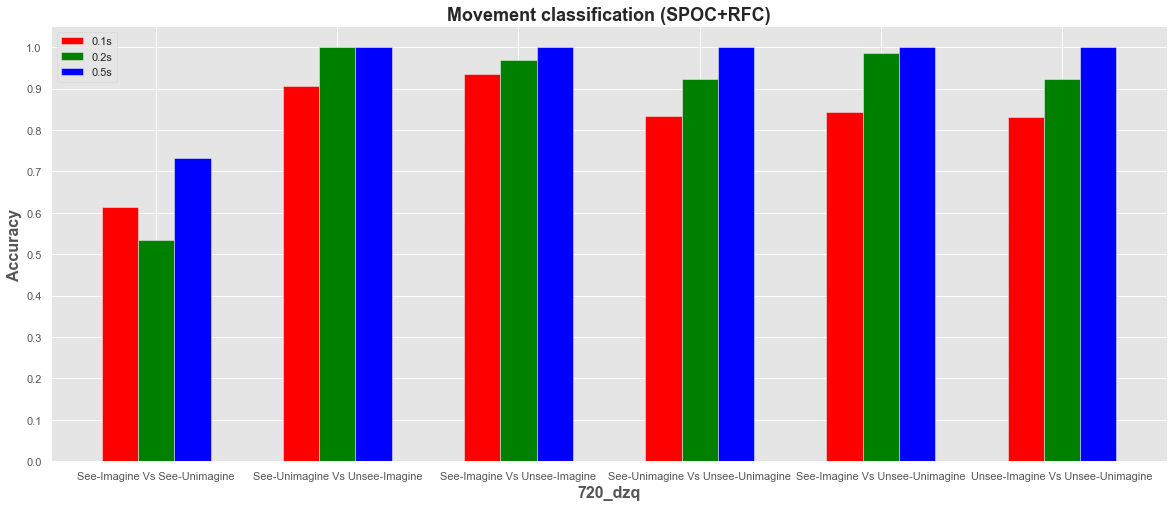

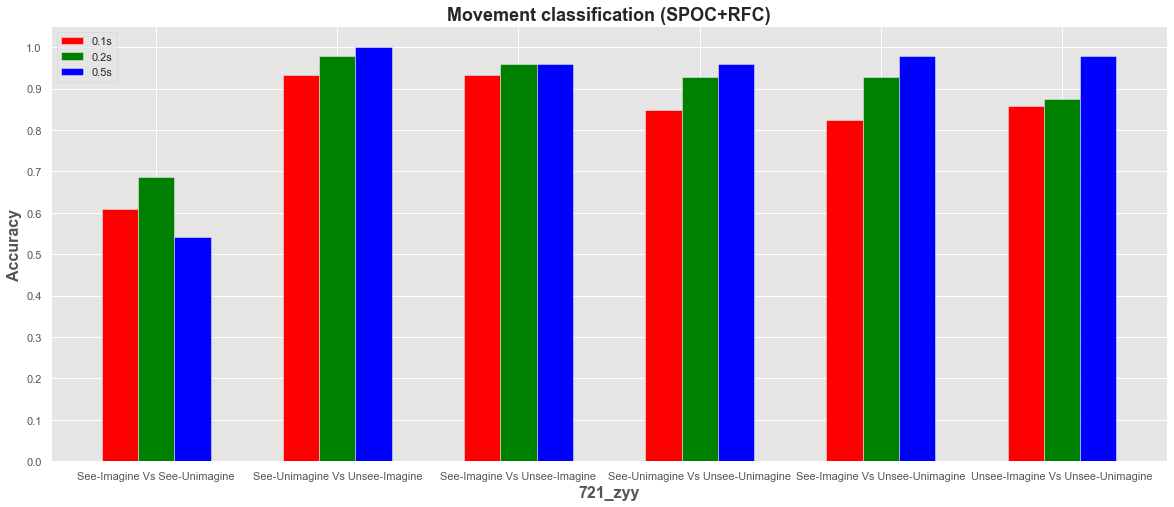

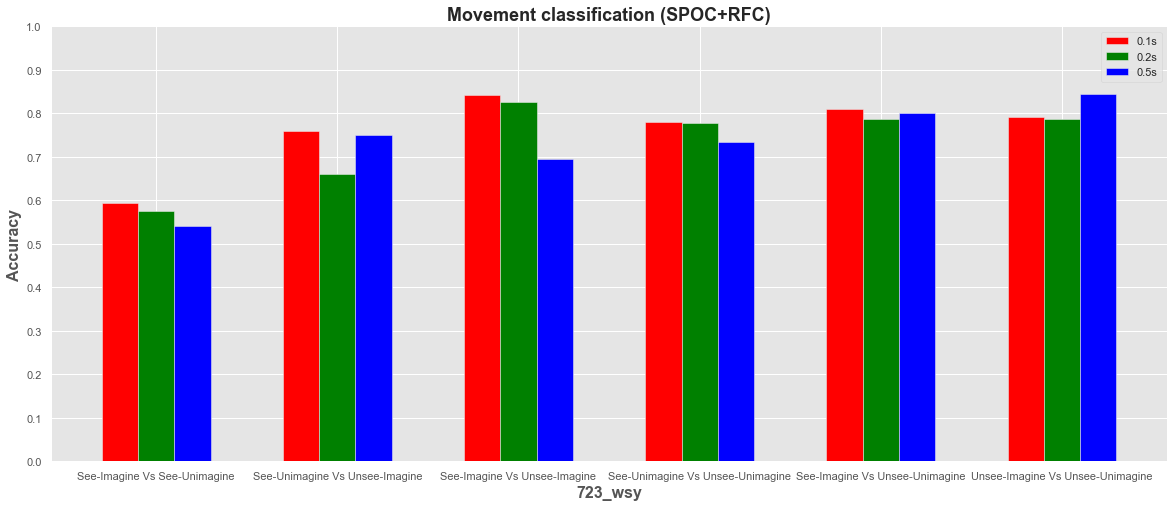

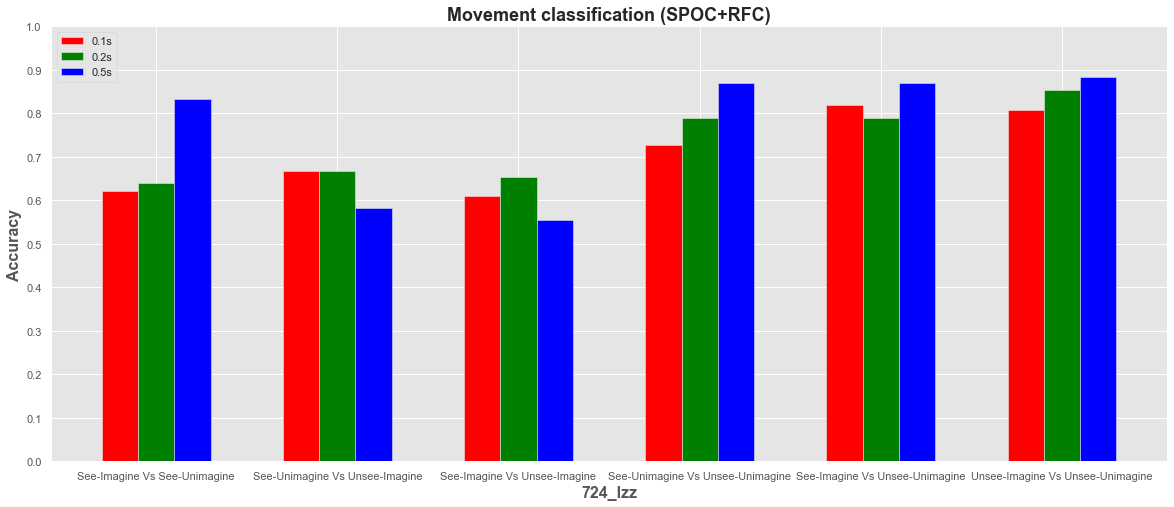

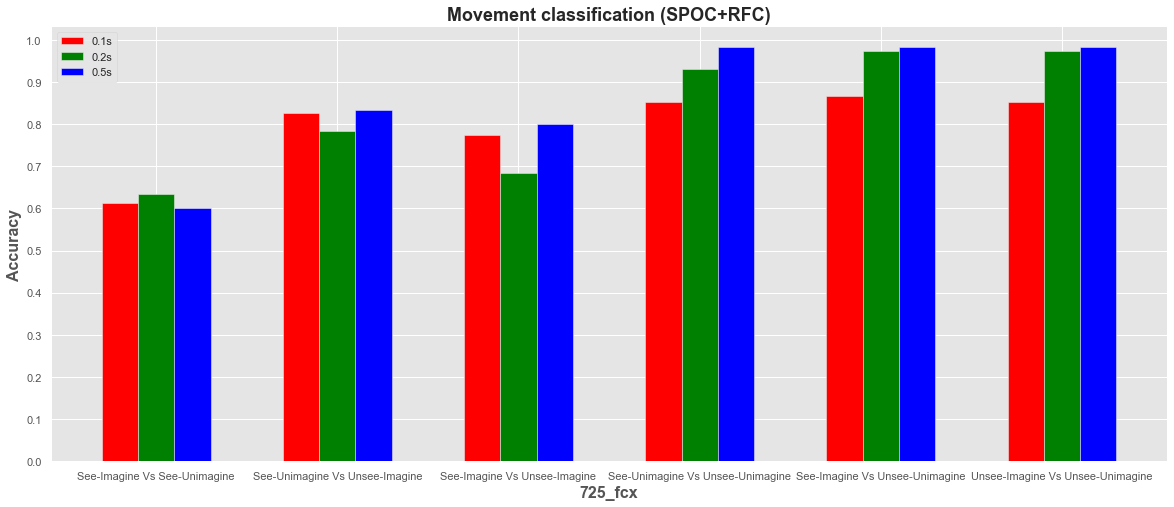

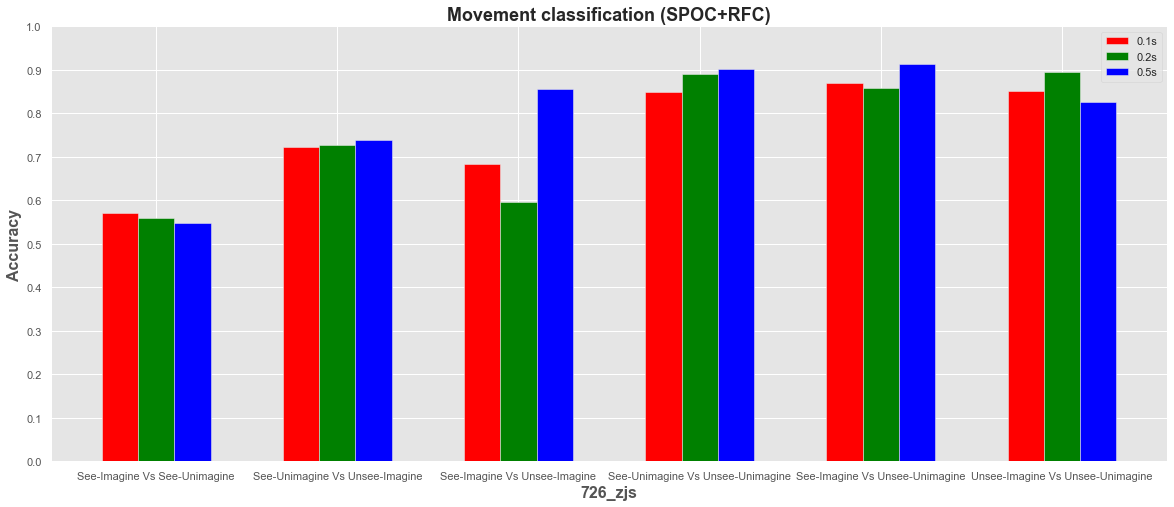

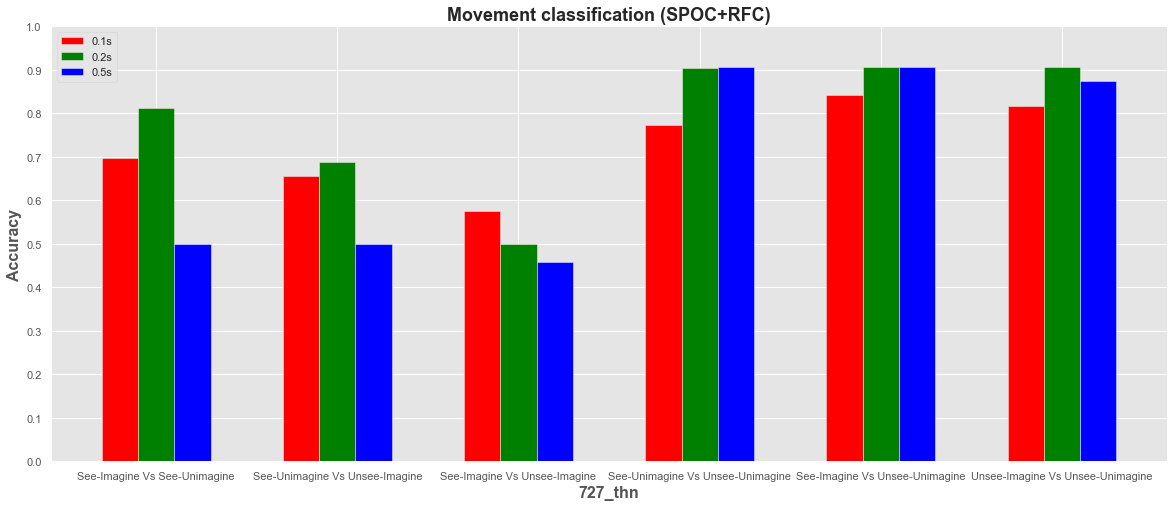

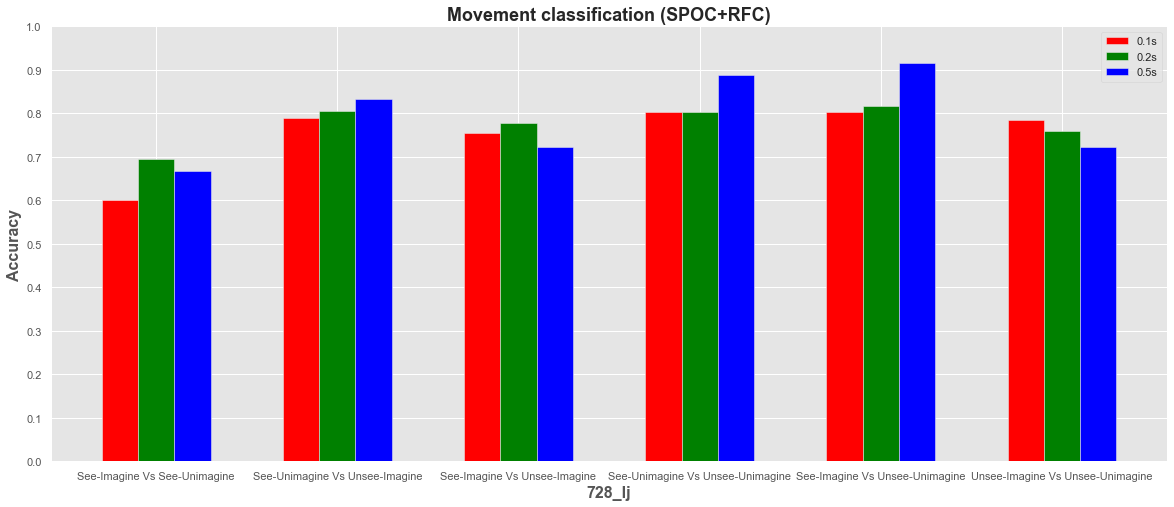

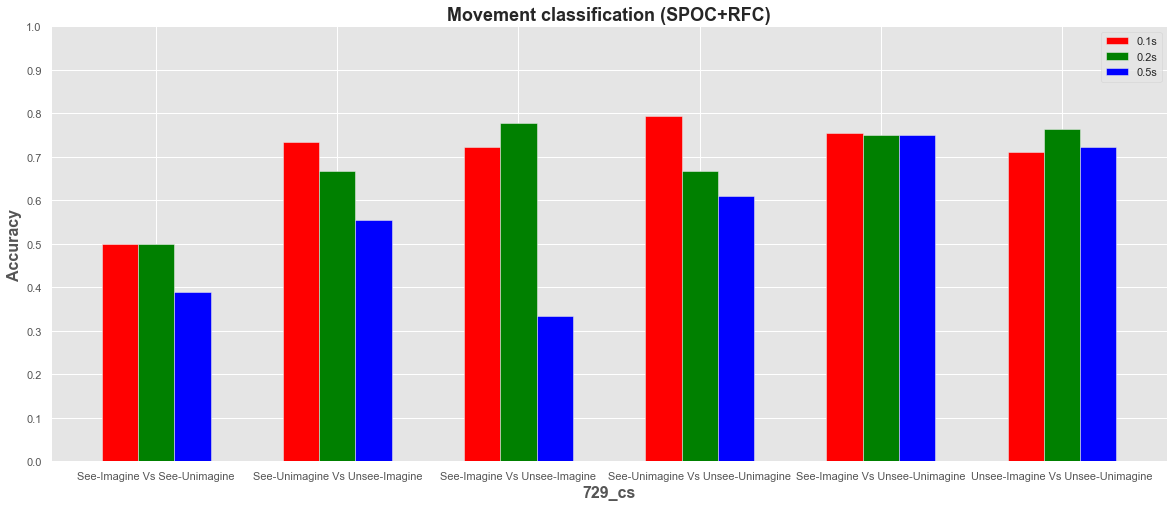

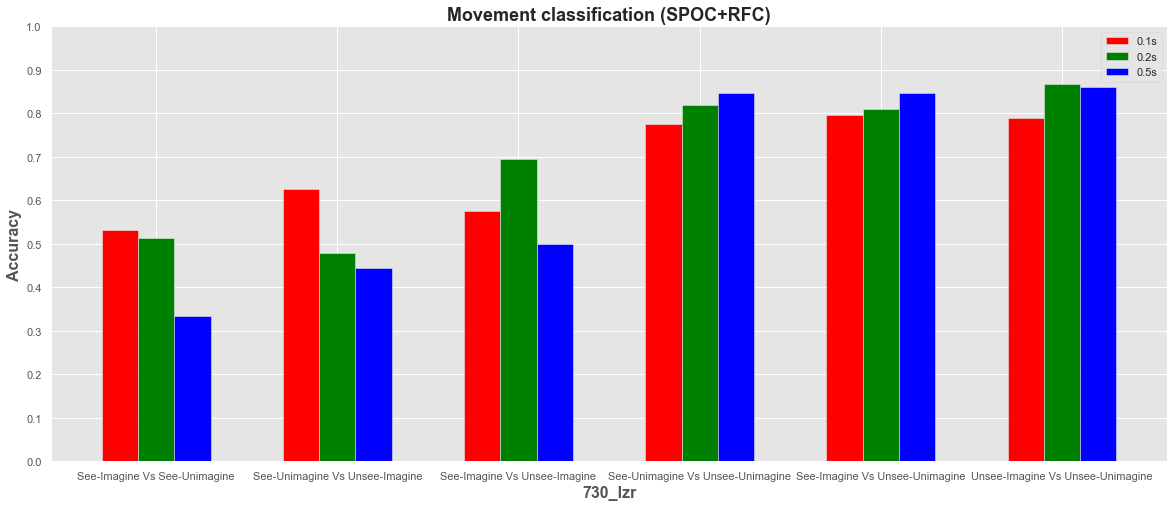

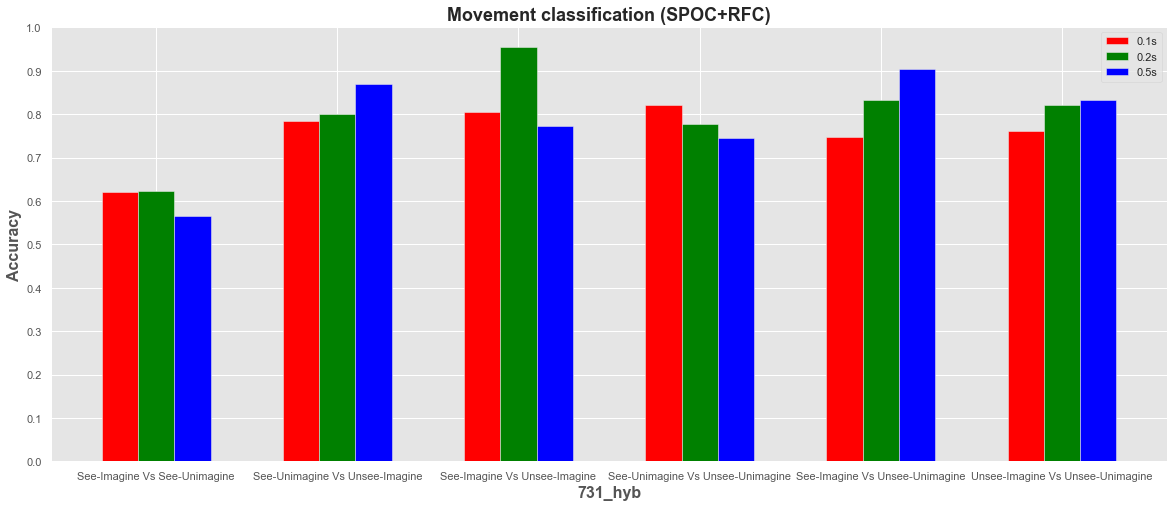

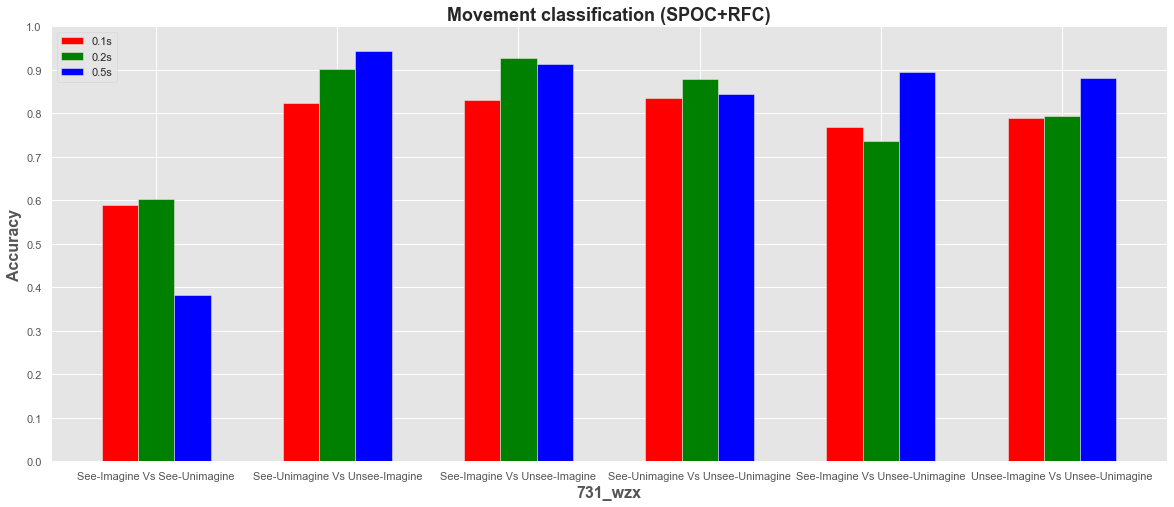

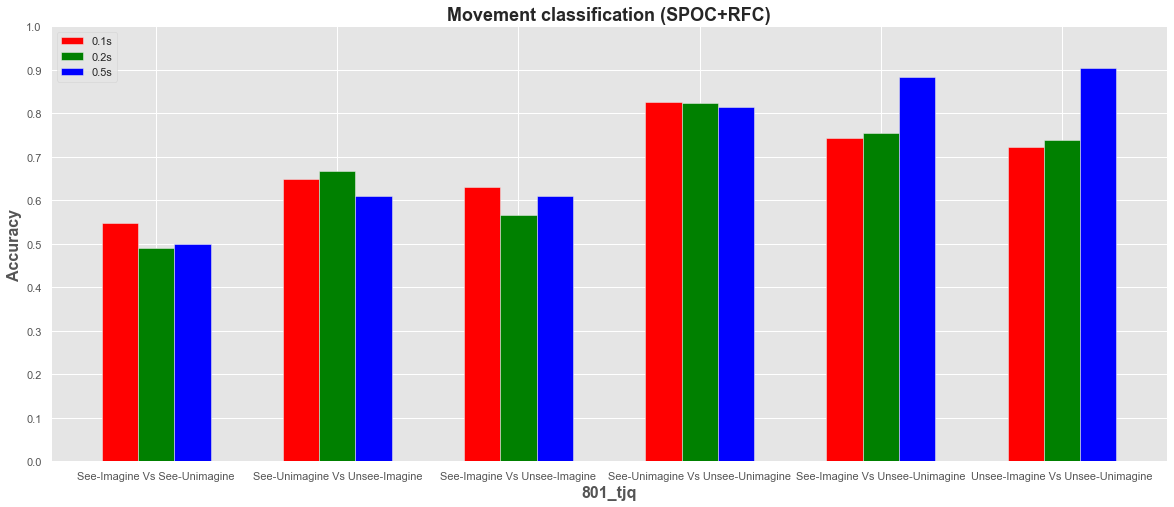

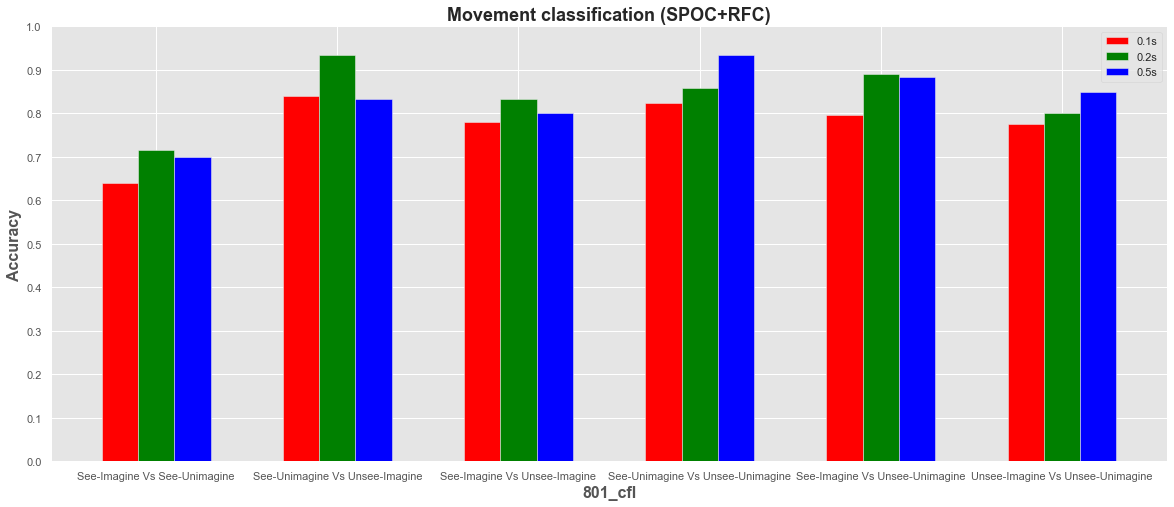

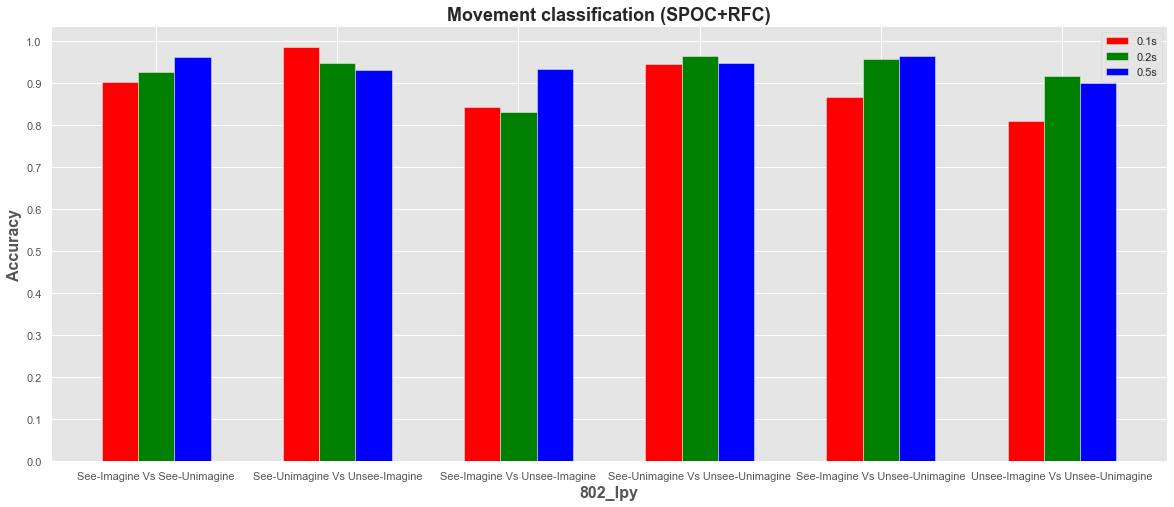

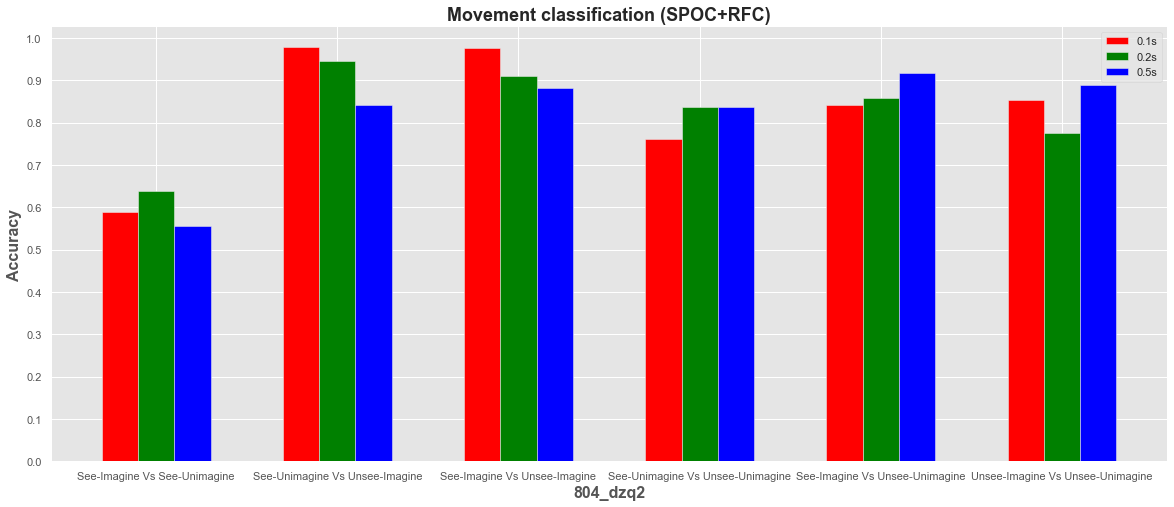

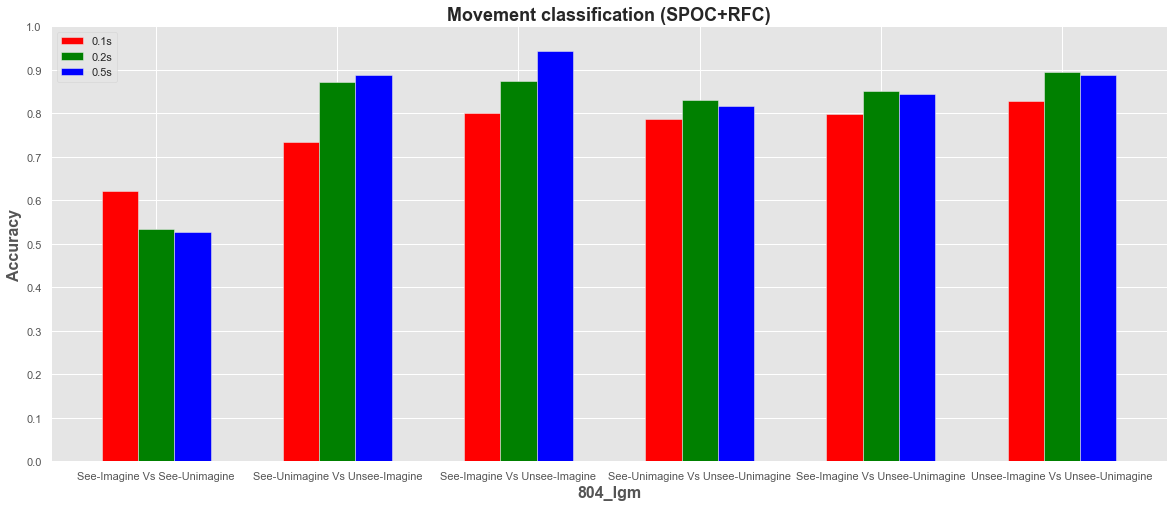

In [134]:
%matplotlib inline
intervals = [1, 2, 5]
for i in range(len(persons)):
    person = persons[i]
    num = nums[i]
    date = dates[i]
    raw = []
    # import data
    for j in range(num):
        f = "E:\大创\data\EEG/0{}{}_eyesImagine{}-edf-pre.edf".format(date, person, j + 1)
        raw_files = read_raw_edf(f, preload=True, stim_channel='auto')
        raw.append(raw_files)
    # data preprocess
    raw = concatenate_raws(raw)
    events, event_dict = mne.events_from_annotations(raw)
    subkey = ['S  1','S  2','S  3','S 10']
    event_ids = dict([(key, event_dict[key]) for key in subkey])
    event_id_compose = [{'S  1':event_ids['S  1'], 'S  2':event_ids['S  2']},
                {'S  1':event_ids['S  1'], 'S  3':event_ids['S  3']},
                {'S  2':event_ids['S  2'], 'S  3':event_ids['S  3']},
                {'S  1':event_ids['S  1'], 'S 10':event_ids['S 10']},
                {'S  2':event_ids['S  2'], 'S 10':event_ids['S 10']},
                {'S  3':event_ids['S  3'], 'S 10':event_ids['S 10']}]
    acc = []
    # model train & fit & predict
    for event_id in event_id_compose:
        tmin, tmax = -0.5, 4.5
        picks = pick_types(raw.info, meg=False, eeg=True, stim=True, eog=False)
        epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
        epochs_data = epochs.get_data()
        labels = epochs.events[:, -1]
        temp = labels.min()
        labels = labels - temp
        for interval in intervals:
            slot_num = int(5 / interval)
            step = int(2500 / slot_num)
            data = []
            labels_new = []
            for k in range(len(epochs_data)):
                epoch = epochs_data[k]
                archer = 0
                tmp = np.delete(epoch, 0, axis=1)
                for slot_id in range(slot_num):
                    inner = []
                    archer = archer + step
                    for channel in range(len(tmp)):
                        inner.append(tmp[channel][archer - step : archer])
                    data.append(inner)
                    labels_new.append(labels[k])
            data = np.array(data)
            labels_new = np.array(labels_new)
            acc.append(csp_rfc(data, labels_new))
            print(acc)

    # result visualization
    plt.style.use("ggplot")
    states = ["See-Imagine Vs See-Unimagine", "See-Unimagine Vs Unsee-Imagine","See-Imagine Vs Unsee-Imagine",\
             "See-Unimagine Vs Unsee-Unimagine","See-Imagine Vs Unsee-Unimagine","Unsee-Imagine Vs Unsee-Unimagine"]
    interval1 = acc[::3]
    interval2 = acc[1::3]
    interval3 = acc[2::3]
    xticks = np.arange(len(states))
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.bar(xticks, interval1, width=0.2, label="0.1s", color="red")
    ax.bar(xticks + 0.2, interval2, width=0.2, label="0.2s", color="green")
    ax.bar(xticks + 0.4, interval3, width=0.2, label="0.5s", color="blue")
    ax.set_title("Movement classification (SPOC+RFC)", fontsize=18, fontweight='heavy')
    ax.set_xlabel("{}_{}".format(date,person), fontsize=16, fontweight='heavy')
    ax.set_ylabel("Accuracy", fontsize=16, fontweight='heavy')
    plt.yticks(np.arange(0, 1.1, 0.1))
    ax.legend()
    # 最后调整x轴标签的位置
    ax.set_xticks(xticks + 0.2)
    ax.set_xticklabels(states)
    plt.savefig("E:/大创/result_脑电/flatted(spoc_rfc)_{}_{}".format(date,person), bbox_inches='tight')
    print('i = {} -- done'.format(i))